# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [2]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Preprocessing

In [4]:
!pip install pandas nltk zemberek-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 4.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141214 sha256=f5b3a362016af76265a0c71592bd7712241db65c3c6d29301bcaf16831c11008
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime


In [5]:
pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

class TurkishTextPreprocessor:
    def __init__(self):
        # Initialize Zemberek objects
        self.morphology = TurkishMorphology.create_with_defaults()
        self.normalizer = TurkishSentenceNormalizer(self.morphology)
        self.extractor = TurkishSentenceExtractor()
        self.tokenizer = TurkishTokenizer.DEFAULT
        self.sc = TurkishSpellChecker(self.morphology)

        # Stop words for Turkish (you can extend this list)
        self.stop_words = {"ve", "ile", "bir", "bu", "ne", "mı", "mu", "mi", "mü", "her", "şey", "çok", "daha", "de", "da", "ki", "ama", "ise",
                           "acaba", "en", "gibi", "için", "neden", "niçin", "niye", "veya", "ya", "yani", "hem", "gereken", "lazım", "olan",
                           "önce", "sonra", "şu", "o", "şu", "göre", "ancak", "yalnız", "madem", "sanki", "güya", "kadar", "ki", "diye", "böyle", "şöyle", "öyle",
                           "bile", "dahi", "beri", "başka", "hariç", "biri", "bence", "sence", "bizce", "sizce", "ona", "buna", "şuna", "onlara", "bunlara",
                           "şunlara", "bize", "size", "onlara", "bizim", "sizin", "onların", "bunun", "şunun", "onun", "bizimki", "sizinki", "onlarınki", "kimse",
                           "kim", "hiçbiri", "birisi", "birileri", "hepsi", "başkası", "bazısı", "çoğu", "birkaçı", "birkaçı", "birkaç", "tümü", "hiç kimse", "herkes", "hep",
                           "hepsi", "nerede", "nerden", "nereye", "nasıl", "ne", "hangisi", "kaç", "nerede", "nereden", "nereye", "nasıl", "hangisi", "kaç", "hiçbir",
                           "diğer", "şey", "herhangi", "bütün", "tüm", "başka", "kendi", "ben", "sen", "o", "biz", "siz", "onlar", "bizatihi", "itibarıyla", "itibariyle",
                           "dolayı", "ötürü", "yüzünden", "ikincisi", "birlikte", "burada", "burda", "şurada", "şurda", "orada", "orda"}

                # Emoji to text mapping
        self.emoji_mapping = {
            # Smileys and Emotion
            "😀": "mutlu", "😃": "mutlu", "😄": "mutlu", "😁": "gülümseme",
            "😆": "kahkaha", "😅": "rahatlama", "😂": "gülme", "🤣": "kahkaha",
            "😊": "mutlu", "😇": "melek", "🙂": "gülümseme", "🙃": "ters",
            "😉": "göz kırpma", "😌": "rahatlama", "😍": "aşk", "🥰": "sevgi",
            "😘": "öpücük", "😗": "öpücük", "😙": "öpücük", "😚": "öpücük",
            "😋": "lezzetli", "😛": "şaka", "😜": "şaka", "😝": "şaka",
            "🤪": "çılgın", "🤨": "şüpheci", "🧐": "inceleme", "🤓": "zeki",
            "😎": "havalı", "🥳": "parti", "😏": "kibir", "😒": "memnuniyetsiz",
            "😞": "üzgün", "😔": "üzgün", "😟": "endişeli", "😕": "şaşkın",
            "🙁": "üzgün", "☹️": "üzüntü", "😢": "üzgün", "😭": "ağlama",
            "😤": "öfke", "😠": "kızgın", "😡": "kızgın", "🤬": "küfür",
            "🤯": "şok", "😳": "utanma", "🥺": "rica", "😨": "korku",
            "😰": "endişe", "😥": "üzüntü", "😓": "terleme", "🤗": "sarılma",
            "🤔": "düşünme", "🤭": "gizli", "🤫": "sessiz", "🤥": "yalan",
            "😶": "sessiz", "😐": "tarafsız", "😑": "tarafsız", "😬": "gergin",
            "🙄": "sıkılmış", "😯": "şaşkınlık", "😦": "şaşkınlık", "😧": "şok",
            "😮": "şaşırma", "😲": "şok", "😴": "uyku", "🤤": "iştah",
            "😵": "baş dönmesi", "🤐": "suskun", "🥴": "sarhoş", "😈": "şeytan",
            "👿": "şeytan", "👹": "iblis", "👺": "kötü ruh", "💀": "kafatası",
            "☠️": "ölüm", "👻": "hayalet", "👽": "uzaylı", "🤖": "robot",

            # Gestures and Body Parts
            "👍": "tamam", "👎": "kötü", "✊": "güç", "👊": "yumruk",
            "🤛": "yumruk sola", "🤜": "yumruk sağa", "👏": "alkış", "🙌": "kutlama",
            "👐": "açık eller", "🤲": "dua", "🤝": "el sıkışma", "🙏": "teşekkür",
            "💪": "güç", "🖐️": "el", "✋": "el", "👌": "tamam",
            "🤌": "ne demek", "🤏": "küçük", "✌️": "barış", "🤞": "şans",
            "🤟": "sevgi", "🤘": "rock", "🤙": "çağrı", "🖖": "vulcan selamı",

            # Hearts and Love
            "❤️": "kalp", "💔": "kalpkırık", "💕": "çift kalp", "💞": "aşk",
            "💓": "atış", "💗": "büyüme", "💖": "parlak", "💘": "ok kalp",
            "💝": "hediye", "💟": "aşk sembolü", "❣️": "büyük aşk",

            # Activities and Objects
            "🎉": "kutlama", "🎊": "parti", "🎁": "hediye", "🎈": "balon",
            "🎂": "doğum günü", "🍰": "pasta", "🎨": "sanat", "🎵": "müzik",
            "🎶": "nota", "🎤": "mikrofon", "🎧": "kulaklık",

            # Weather and Nature
            "☀️": "güneş", "🌤️": "güneşli", "⛅": "bulutlu", "☁️": "bulut",
            "🌧️": "yağmur", "⛈️": "fırtına", "🌩️": "şimşek", "🌪️": "tornado",
            "🌈": "gökkuşağı", "🔥": "ateş", "💧": "damla", "❄️": "kar",

            # Animals and Plants
            "🐶": "köpek", "🐱": "kedi", "🐭": "fare", "🐹": "hamster",
            "🐰": "tavşan", "🦊": "tilki", "🐻": "ayı", "🐼": "panda",
            "🦁": "aslan", "🐯": "kaplan", "🐨": "koala", "🐮": "inek",
            "🐷": "domuz", "🐸": "kurbağa", "🐵": "maymun", "🦄": "tek boynuzlu at",

        }

    def remove_irrelevant_content(self, text):
        """Removes HTML tags, URLs, and excessive whitespace."""
        text = re.sub(r"http\S+", "", text)  # Remove URLs
        text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
        text = re.sub(r"\s+", " ", text)  # Remove excessive whitespace
        return text

    def normalize_turkish_chars(self, text):
        """Normalizes common Turkish character variations."""
        text = text.replace("Ý", "İ").replace("Ð", "Ğ").replace("Þ", "Ş")
        text = text.replace("ý", "ı").replace("ð", "ğ").replace("þ", "ş")
        return text

    def lowercase_text(self, text):
        """Converts text to lowercase."""
        return text.lower()

    def tokenize_text(self, text):
        """Tokenizes the text using Zemberek tokenizer."""
        tokens = self.tokenizer.tokenize(text)
        return [token.content for token in tokens if token is not None and token.content.strip()]

    def remove_stop_words(self, tokens):
        """Removes Turkish stop words from a list of tokens."""
        return [token for token in tokens if token not in self.stop_words]

    def lemmatize_text(self, tokens):
        """Lemmatizes tokens using Zemberek."""
        lemmas = []
        for token in tokens:
            try:
                analysis_results = self.morphology.analyze(token)
                if analysis_results.analysis_results:
                    best_analysis = analysis_results.analysis_results[0]
                    if best_analysis:
                        lemmas.append(best_analysis.get_stem())
                    else:
                        lemmas.append(token)
                else:
                    lemmas.append(token)
            except Exception as e:
                print(f"Lemmatization error for token '{token}': {e}")
                lemmas.append(token)  # Fallback to the original token
        return lemmas

    def handle_emojis(self, text):
        """Converts emojis to corresponding text based on a mapping."""
        for emoji, meaning in self.emoji_mapping.items():
            text = text.replace(emoji, f" {meaning} ")
        return text

    def handle_hashtags(self, tokens, hashtag_handling="keep_separate"):
        """Handles hashtags based on the specified method."""
        processed_tokens = []
        for token in tokens:
            if token.startswith("#"):
                if hashtag_handling == "keep_separate":
                    processed_tokens.append(token)
                elif hashtag_handling == "remove":
                    continue  # Remove the hashtag
                elif hashtag_handling == "treat_as_word":
                    processed_tokens.append(token[1:])  # Remove '#' and treat as a regular word
            else:
                processed_tokens.append(token)
        return processed_tokens

    def handle_mentions(self, tokens, mention_handling="keep_separate"):
        """Handles user mentions based on the specified method."""
        processed_tokens = []
        for token in tokens:
            if token.startswith("@"):
                if mention_handling == "keep_separate":
                    processed_tokens.append(token)
                elif mention_handling == "remove":
                    continue  # Remove the mention
                elif mention_handling == "treat_as_word":
                    processed_tokens.append(token[1:])  # Remove '@' and treat as a regular word
            else:
                processed_tokens.append(token)
        return processed_tokens

    def preprocess_text(self, text, hashtag_handling="keep_separate", mention_handling="keep_separate"):
        """Performs the complete preprocessing pipeline."""
        if not text or not isinstance(text, str):
            return ""  # Return an empty string for invalid input

        text = self.remove_irrelevant_content(text)
        text = self.normalize_turkish_chars(text)
        text = self.handle_emojis(text)
        text = self.lowercase_text(text)
        tokens = self.tokenize_text(text)
        tokens = self.handle_hashtags(tokens, hashtag_handling)
        tokens = self.handle_mentions(tokens, mention_handling)
        tokens = self.remove_stop_words(tokens)
        tokens = self.lemmatize_text(tokens)
        return " ".join(tokens)

    def preprocess_dataframe(self, df, text_column, hashtag_handling="keep_separate", mention_handling="keep_separate"):
        """Applies preprocessing to a specific column in a DataFrame."""
        df_copy = df.copy()
        df_copy[text_column] = df_copy[text_column].apply(lambda x: self.preprocess_text(x, hashtag_handling, mention_handling))
        return df_copy


preprocessor = TurkishTextPreprocessor()


In [ ]:
import re
import nltk
import pandas as pd

# -------------------- Training Data --------------------
corpus_train = []
train_usernames = []
i = 0
for username, posts in username2posts_train.items():
    print(i)
    i = i+1
    train_usernames.append(username)
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None or post_caption == "":
            continue

        post_caption = preprocessor.preprocess_text(post_caption, hashtag_handling="treat_as_word", mention_handling="remove")
        if post_caption != "":  # Add this check for empty strings after preprocessing
            cleaned_captions.append(post_caption)

    if cleaned_captions:  # Check if there are any cleaned captions for the user
      user_post_captions = "\n".join(cleaned_captions)
      corpus_train.append(user_post_captions)
    else:
      print(f"Warning: User {username} has no valid posts after preprocessing.")
      corpus_train.append("")  # Add an empty string to maintain alignment with train_usernames

# -------------------- Test Data --------------------
# (Similar changes in the test data loop)


# -------------------- TF-IDF Feature Extraction --------------------


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
Lemmatization error for token '': 'NoneType' object has no attribute 'content'
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
Lemmatization error for token '': 'NoneType' object has no attrib

In [ ]:
train_data_df.to_csv('/content/drive/My Drive/Project/train_data.csv', index=False)

In [ ]:
import pandas as pd

train_data_df = pd.read_csv('/content/drive/My Drive/Project/train_data.csv')
print(train_data_df.head())


               username                                   cleaned_captions  \
0            deparmedya  cumhuriyet 100. yıl kutlu olsun♾️🇹🇷\noriflame ...   
1            kafesfirin  bugün fincan köpük türk kahve taçlan . aşk kaf...   
2              vimerang  saygı özlemle🖤 atatürk 10kasım 10kasim1938 vim...   
3     mustafa_yalcinn38  📍altınoluk çevre , şehir i̇klim değişik bakan ...   
4  zorluenergysolutions  gün enerjik sohbet devam et ister mi ? dijital...   

                  label  
0                  tech  
1                  food  
2                  tech  
3  health and lifestyle  
4                  tech  


In [ ]:
train_data_df

username  \
0                deparmedya   
1                kafesfirin   
2                  vimerang   
3         mustafa_yalcinn38   
4      zorluenergysolutions   
...                     ...   
2736    tatlidunyasidergisi   
2737  yerindengelsin.com.tr   
2738       woodtechistanbul   
2739               netsvadi   
2740          herbisiatolye   

                                       cleaned_captions                 label  
0     cumhuriyet 100. yıl kutlu olsun♾️🇹🇷\noriflame ...                  tech  
1     bugün fincan köpük türk kahve taçlan . aşk kaf...                  food  
2     saygı özlemle🖤 atatürk 10kasım 10kasim1938 vim...                  tech  
3     📍altınoluk çevre , şehir i̇klim değişik bakan ...  health and lifestyle  
4     gün enerjik sohbet devam et ister mi ? dijital...                  tech  
...                                                 ...                   ...  
2736  emelaydinbutikpastacilik butik . pastacilar . ...                  food  
2737  berliner almanekmeği hercumartesi\nalmanbavyer...                  food  
2738  “ söyle hakikat ol gün , se medeni beşeriyet d...                  tech  
2739  nets vadi̇de nefes kampi 16-17 aralik az sayı ...  health and lifestyle  
2740  gurdjieff kutsal dans öğreti çalış . 2015 de p...  health and lifestyle  

[2741 rows x 3 columns]

In [ ]:

y_train = [username2_category.get(uname, "NA") for uname in train_data_df['username']]

# Display a sample of the DataFrame
print(train_data_df.head())



NameError: name 'train_usernames' is not defined

In [ ]:
train_classification_df = pd.read_csv("/content/drive/My Drive/Project/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [ ]:


# Compute class weights
class_counts = {
    'art': 191,
    'entertainment': 323,
    'fashion': 299,
    'food': 511,
    'gaming': 13,
    'health and lifestyle': 503,
    'mom and children': 149,
    'sports': 113,
    'tech': 346,
    'travel': 294
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count) for cls, count in class_counts.items()
}
class_weights

In [ ]:
train_data_path = "/content/drive/My Drive/Project/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [ ]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

In [ ]:
train_profile_df.info()

In [ ]:
columns_to_drop = ['post_count', 'business_category_name', 'id', 'category_enum', 'bio_links', 'eimu_id', 'fbid', 'business_address_json', 'business_contact_method', 'profile_pic_url', 'profile_picture_base64']
train_profile_df.drop(columns=columns_to_drop, inplace=True)

train_profile_df = train_profile_df.dropna(axis=1, how='all')

print(train_profile_df.info())
print(train_profile_df.shape)

In [ ]:
columns_to_update = ['biography', 'full_name', 'external_url', 'category_name']
train_profile_df[columns_to_update] = train_profile_df[columns_to_update].fillna('Unknown')

print(train_profile_df.info())

In [ ]:
# Adding a category column based on username2_category
train_profile_df['category'] = [
    username2_category.get(uname, "NA") for uname in train_profile_df['username']
]


In [ ]:
# Convert columns with only `True` or `False` to boolean
for col in train_profile_df.columns:
    if train_profile_df[col].dropna().isin([True, False]).all():  # Check for True/False values
        train_profile_df[col] = train_profile_df[col].astype(bool)

In [ ]:
pip install transformers datasets torch


# Category_name based Predictions

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Assuming `train_data_df` contains the posts, with columns:
# 'username', 'cleaned_captions', 'label'
# 'train_profile_df' contains the 'username' and 'category_name' mapping
# 'category_name' is used to identify the category label for posts in the training data

# Step 1: Split the data into train and test sets from train_data_df
train_data_df, test_data_df = train_test_split(train_data_df, test_size=0.2, random_state=42)

# Step 2: Merge train and test data with the train_profile_df to get the category_name based on username
train_data_with_categories = pd.merge(train_data_df, train_profile_df[['username', 'category_name']], on='username', how='left')
test_data_with_categories = pd.merge(test_data_df, train_profile_df[['username', 'category_name']], on='username', how='left')

# Step 3: Vectorize 'cleaned_captions' with TF-IDF for both train and test data
tfidf = TfidfVectorizer(max_df=0.85, min_df=1, max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_data_with_categories['cleaned_captions'].astype(str))
X_test_tfidf = tfidf.transform(test_data_with_categories['cleaned_captions'].astype(str))

# Step 4: Extract labels (categories) for train and test data
y_train = train_data_with_categories['label']
y_test = test_data_with_categories['label']

# Step 5: Train SVC model on the training data
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)
svc.fit(X_train_tfidf, y_train)

# Step 6: Define function to predict category based on category name
def predict_category_based_on_name(category_name, train_data_with_categories):
    """Check if category_name exists in train data and return the majority category."""
    category_data = train_data_with_categories[train_data_with_categories['category_name'] == category_name]

    if not category_data.empty:
        # If the category name exists in train data, return the majority category
        majority_category = category_data['label'].mode()[0]
        return majority_category
    else:
        # If category name does not exist in train data, use majority category of category_name
        # Get the majority category for the same `category_name` from the training data
        category_data = train_data_with_categories[train_data_with_categories['category_name'] == category_name]

        # If category_name is found, return the majority category
        if not category_data.empty:
            majority_category = category_data['label'].mode()[0]
            return majority_category

        # If no match for category_name in training data, fallback to SVC prediction
        # This fallback happens only if no matching category_name exists
        category_tfidf = tfidf.transform([category_name])

        # Predict using the trained SVC model
        predicted_category = svc.predict(category_tfidf)
        return predicted_category[0]

# Step 7: Predict categories for the test data
predicted_categories = []

for index, row in test_data_with_categories.iterrows():
    category_name = row['category_name']  # Assuming 'category_name' in test data is the category name
    predicted_category = predict_category_based_on_name(category_name, train_data_with_categories)
    predicted_categories.append(predicted_category)

# Step 8: Evaluate the predictions
test_data_with_categories['predicted_category'] = predicted_categories
test_data_with_categories['is_correct'] = test_data_with_categories['label'] == test_data_with_categories['predicted_category']
accuracy = test_data_with_categories['is_correct'].mean()
print(f"Test Accuracy: {accuracy:.2%}")

# Display the first few rows of the results
print(test_data_with_categories[['username', 'label', 'predicted_category', 'is_correct']].head())


Test Accuracy: 39.50%
          username          label    predicted_category  is_correct
0  sakarya_gurmesi           food  health and lifestyle       False
1      atvmilyoner  entertainment                  food       False
2       peramuzesi            art                   art        True
3         gedizbld         travel  health and lifestyle       False
4         hamsipub           food                  food        True


TF-IDF Model Accuracy on Test Set: 0.668488160291439

Classification Report:
                      precision    recall  f1-score   support

                 art       0.34      0.26      0.30        38
       entertainment       0.46      0.42      0.44        65
             fashion       0.55      0.70      0.62        60
                food       0.91      0.87      0.89       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.68      0.70      0.69       100
    mom and children       0.58      0.50      0.54        30
              sports       0.68      0.65      0.67        23
                tech       0.73      0.87      0.79        69
              travel       0.72      0.66      0.69        59

            accuracy                           0.67       549
           macro avg       0.57      0.56      0.56       549
        weighted avg       0.66      0.67      0.66       549


Adjusted Predictions (using category_name):
Adjuste

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


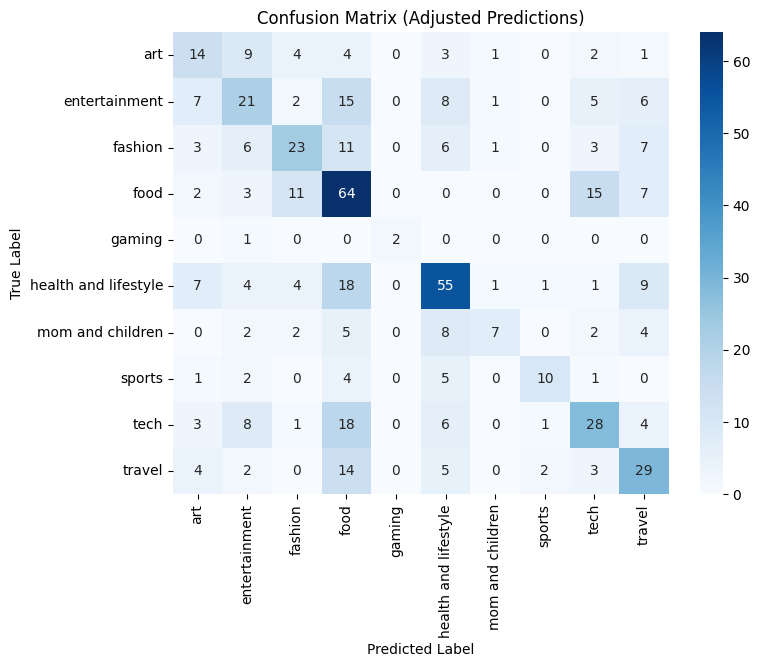

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Handle missing values in cleaned_captions by replacing them with an empty string
train_data_df['cleaned_captions'] = train_data_df['cleaned_captions'].fillna('').astype(str)
train_profile_df['category_name'] = train_profile_df['category_name'].fillna('Unknown')  # Handle missing categories

# Merge the train_data_df and train_profile_df on a shared key (assuming 'id' exists in both DataFrames)
train_df = pd.merge(train_data_df, train_profile_df[['category_name']], left_index=True, right_index=True)

# Split data into training and test (80% train, 20% test)
X = train_df['cleaned_captions']  # Text data for TF-IDF
y = train_df['label']  # Labels for classification
categories = train_df['category_name']  # Category names for adjustment

# Split the data
X_train, X_test, y_train, y_test, categories_train, categories_test = train_test_split(
    X, y, categories, test_size=0.2, stratify=y, random_state=42
)

# Step 1: TF-IDF vectorization
tfidf = TfidfVectorizer(max_df=0.85, min_df=1, max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 2: Train SVC classifier
svc = SVC(probability=True, kernel='linear', class_weight='balanced')
svc.fit(X_train_tfidf, y_train)

# Step 3: Predict the categories using the TF-IDF model on the test data
y_pred_tfidf = svc.predict(X_test_tfidf)

# Evaluate the performance of TF-IDF based model on the test set
print("TF-IDF Model Accuracy on Test Set:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

# Step 4: Adjust predictions based on 'category_name' from train_profile_df
# Find majority label per category_name in training data
category_majority_label = (
    pd.DataFrame({'category_name': categories_train, 'label': y_train})
    .groupby('category_name')['label']
    .agg(lambda x: x.mode()[0])  # Mode to find majority label
    .to_dict()
)

# Adjust predictions based on majority labels for the category
adjusted_predictions = []
for i, category_name in enumerate(categories_test):
    if category_name in category_majority_label:
        adjusted_predictions.append(category_majority_label[category_name])
    else:
        adjusted_predictions.append(y_pred_tfidf[i])  # Fallback to TF-IDF prediction

# Step 5: Evaluate the adjusted predictions
adjusted_predictions = np.array(adjusted_predictions)

print("\nAdjusted Predictions (using category_name):")
print("Adjusted Accuracy:", accuracy_score(y_test, adjusted_predictions))

# Show the classification report and confusion matrix
print("\nClassification Report for Adjusted Predictions:")
print(classification_report(y_test, adjusted_predictions))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, adjusted_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Predictions)')
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Handle missing values in `category_name`
train_profile_df['category_name'] = train_profile_df['category_name'].fillna('Unknown')

# Step 1: Split the unique category names (20% for clustering and 80% for classification)
# Get unique category names
unique_categories = train_profile_df['category_name'].unique()

# Split the unique category names into train (for clustering) and test (for classification)
train_categories, test_categories = train_test_split(unique_categories, test_size=0.2, random_state=42)

# Step 2: Filter the original data based on the split category names
train_data_for_clustering = train_profile_df[train_profile_df['category_name'].isin(train_categories)]
remaining_data = train_profile_df[train_profile_df['category_name'].isin(test_categories)]

# Step 3: Get embeddings for these unique categories (one embedding per category_name)
category_embeddings = model.encode(train_data_for_clustering['category_name'].astype(str).tolist())

# Step 4: Apply clustering (e.g., KMeans) to the unique categories
num_clusters = int(len(train_categories)/4)  # Number of clusters equals the number of unique categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(category_embeddings)

# Step 5: Assign each cluster the corresponding category label based on majority voting
cluster_to_category = {}
for cluster in range(num_clusters):
    # Get the indices of the data points assigned to the current cluster
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]

    # Get the corresponding category_names and their actual categories
    cluster_category_names = train_data_for_clustering.iloc[cluster_indices]['category_name']
    cluster_categories = train_data_for_clustering.iloc[cluster_indices]['category']

    # Assign the most frequent category name to the cluster (majority voting)
    most_common_category = cluster_categories.mode()[0]
    cluster_to_category[cluster] = most_common_category

# Step 6: Get embeddings for the remaining data (the second 80% for classification)
remaining_embeddings = model.encode(remaining_data['category_name'].astype(str).tolist())

# Step 7: Assign each remaining data point to the closest cluster
predicted_categories = []
for emb in remaining_embeddings:
    # Compute cosine similarities with each cluster centroid
    similarities = cosine_similarity([emb], kmeans.cluster_centers_)
    closest_cluster = np.argmax(similarities)

    # Get the most frequent category in the closest cluster (majority vote)
    predicted_categories.append(cluster_to_category[closest_cluster])

# Step 8: Assign predicted categories to the second half of the data (80% split)
remaining_data['predicted_category'] = predicted_categories

# Step 9: Evaluate the classification
remaining_data['is_correct'] = remaining_data['category'] == remaining_data['predicted_category']
accuracy = remaining_data['is_correct'].mean()
print(f"Classification Accuracy: {accuracy:.2%}")

# Display the first few rows of the results
print(remaining_data[['category_name', 'category', 'predicted_category', 'is_correct']].head(20))


Classification Accuracy: 43.52%
              category_name              category    predicted_category  \
3                Politician  health and lifestyle         entertainment   
6          Software Company                  tech                  tech   
8               Sports Club                sports                sports   
12            Health/beauty  health and lifestyle  health and lifestyle   
19              Bridal Shop               fashion               fashion   
31            Grocery Store                  food                  food   
41           Footwear store               fashion               fashion   
44               Politician  health and lifestyle         entertainment   
51            Health/beauty  health and lifestyle  health and lifestyle   
67            Video creator         entertainment                travel   
71   Theatrical Productions         entertainment         entertainment   
72                   Editor         entertainment                   

<ipython-input-53-8d4014b8e5c1>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_data['predicted_category'] = predicted_categories
<ipython-input-53-8d4014b8e5c1>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_data['is_correct'] = remaining_data['category'] == remaining_data['predicted_category']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handle missing values (NaN) in cleaned_captions by replacing them with an empty string
train_data_df['cleaned_captions'] = train_data_df['cleaned_captions'].fillna('')

# Ensure that all cleaned_captions are of string type
train_data_df['cleaned_captions'] = train_data_df['cleaned_captions'].astype(str)

# Split data into training and test (80% train, 20% test)
X = train_data_df['cleaned_captions']  # Text data for TF-IDF
y = train_data_df['label']  # Labels for classification

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 1: Create a pipeline with TF-IDF and SVC classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.85, min_df=1, max_features=5000, ngram_range=(1, 2))),
    ('svc', SVC(probability=True, kernel='linear', class_weight='balanced'))
])

# Perform Grid Search for tuning TF-IDF and SVC hyperparameters
param_grid = {
    'tfidf__max_df': [0.75, 0.85],
    'tfidf__min_df': [1],
    'tfidf__max_features': [5000],
    'tfidf__ngram_range': [(1, 2)],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=10)
grid_search.fit(X_train, y_train)

# Get the best model after GridSearch
best_model = grid_search.best_estimator_

# Step 2: Predict the categories using the TF-IDF model on the test data
y_pred_tfidf = best_model.predict(X_test)

# Evaluate the performance of TF-IDF based model on the test set
print("TF-IDF Model Accuracy on Test Set:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

# Step 3: Adjust predictions based on 'category_name' from train_profile_df
category_mapping = dict(zip(train_profile_df['category_name'], train_profile_df['category_enum']))

# Get category names for the test data (here assuming you have a similar structure for the test data)
test_category_name = train_profile_df.loc[X_test.index, 'category_name']  # Ensure alignment with test data
adjusted_predictions = []

for i, category_name in enumerate(test_category_name):
    if category_name in category_mapping:
        adjusted_predictions.append(category_mapping[category_name])
    else:
        adjusted_predictions.append('Unknown')  # Default if no match is found

# Step 4: Adjust the predictions and print final evaluation
adjusted_predictions = np.array(adjusted_predictions)

print("\nAdjusted Predictions (using category_enum):")
print("Adjusted Accuracy:", accuracy_score(y_test, adjusted_predictions))

# Show the classification report and confusion matrix
print("\nClassification Report for Adjusted Predictions:")
print(classification_report(y_test, adjusted_predictions))

cm = confusion_matrix(y_test, adjusted_predictions)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Predictions)')
plt.show()


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[CV 1/3; 1/2] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.632 total time= 1.3min
[CV 2/3; 1/2] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[CV 2/3; 1/2] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.643 total time=  54.7s
[CV 3/3; 1/2] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[CV 3/3; 1/2] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.627 total time=  58.6s
[CV 1/3; 2/2] START tfidf__max_df=0.85, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[CV 1/3; 2/2] END tfidf__max_df=0.85, tfidf__max_features=5000, tfidf__min_df=1, tfid

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyError: 'category_enum'

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Load the pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Handle missing values in `category_name`
train_profile_df['category_name'] = train_profile_df['category_name'].fillna('Unknown')

# Step 1: Get embeddings for category_name
train_profile_df['category_name_embedding'] = list(model.encode(train_profile_df['category_name'].astype(str).tolist()))

# Step 2: Cosine similarity between category_name embedding and category embedding
# We first need embeddings for category (if available) or use the same as category_name
train_profile_df['category_embedding'] = list(model.encode(train_profile_df['category'].astype(str).tolist()))

# Compute cosine similarity between `category_name` embedding and `category` embedding
train_profile_df['cosine_similarity'] = [
    cosine_similarity([category_name_emb], [category_emb])[0][0]
    for category_name_emb, category_emb in zip(train_profile_df['category_name_embedding'], train_profile_df['category_embedding'])
]

# Step 3: Train a classifier to predict `category` from `category_name`
X = np.array(train_profile_df['category_name_embedding'].tolist())
y = train_profile_df['category'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2%}")

# Step 4: KMeans clustering based on category_name embeddings
from sklearn.cluster import KMeans

# Perform KMeans clustering
num_clusters = len(train_profile_df['category'].unique())  # Set the number of clusters as the number of unique categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_profile_df['cluster'] = kmeans.fit_predict(X)

# Assign the most frequent category to each cluster
cluster_to_category = {}
for cluster in range(num_clusters):
    cluster_data = train_profile_df[train_profile_df['cluster'] == cluster]
    most_common_category = cluster_data['category'].mode()[0]
    cluster_to_category[cluster] = most_common_category

# Step 5: Check cluster purity - how well each cluster corresponds to a category
cluster_purity = []
for cluster, category in cluster_to_category.items():
    cluster_data = train_profile_df[train_profile_df['cluster'] == cluster]
    correct_predictions = (cluster_data['category'] == category).sum()
    purity = correct_predictions / len(cluster_data)
    cluster_purity.append((cluster, category, purity))

# Print cluster purity
print("\nCluster Purity:")
for cluster, category, purity in cluster_purity:
    print(f"Cluster {cluster} ({category}): Purity = {purity:.2%}")

# Optional: Display some rows of the result for review
print(train_profile_df[['category_name', 'category', 'cosine_similarity', 'cluster', 'category_name_embedding']].head())


Classification Accuracy: 46.99%

Cluster Purity:
Cluster 0 (sports): Purity = 56.34%
Cluster 1 (food): Purity = 22.14%
Cluster 2 (food): Purity = 32.64%
Cluster 3 (food): Purity = 50.57%
Cluster 4 (travel): Purity = 18.65%
Cluster 5 (entertainment): Purity = 25.38%
Cluster 6 (tech): Purity = 24.96%
Cluster 7 (fashion): Purity = 47.24%
Cluster 8 (health and lifestyle): Purity = 73.45%
Cluster 9 (health and lifestyle): Purity = 30.38%
    category_name              category  cosine_similarity  cluster  \
0  Local business                  tech           0.206465        6   
1           Brand                  food           0.276183        6   
2         Unknown                  tech           0.273384        1   
3      Politician  health and lifestyle           0.244579        5   
4         Unknown                  tech           0.273384        1   

                             category_name_embedding  
0  [0.078137696, 0.008797453, 0.054135215, -0.006...  
1  [-0.09075169, 0.0284749

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Assuming `train_data_df` contains the cleaned captions and their respective `category` labels

# Step 1: Vectorize `cleaned_captions` with TF-IDF
tfidf = TfidfVectorizer(max_df=0.65, min_df=1, max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(train_data_df['cleaned_captions'].astype(str))

# Step 2: Extract labels
y = train_data_df['label']

# Step 3: Split the data into training and testing sets, ensuring categories don't overlap between the sets
train_data_df_train, train_data_df_test = train_test_split(
    train_data_df, test_size=0.2, random_state=42, stratify=y)

# Get TF-IDF for the training and test sets
X_train_tfidf = tfidf.transform(train_data_df_train['cleaned_captions'].astype(str))
X_test_tfidf = tfidf.transform(train_data_df_test['cleaned_captions'].astype(str))

# Step 4: Apply clustering on the training data
num_clusters = len(train_data_df_train['label'].unique())  # One cluster per unique category
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_data_df_train['cluster'] = kmeans.fit_predict(X_train_tfidf)

# Step 5: Assign the majority category to each cluster in the training set
cluster_to_category = {}
for cluster in range(num_clusters):
    cluster_data = train_data_df_train[train_data_df_train['cluster'] == cluster]
    most_common_category = cluster_data['label'].mode()[0]
    cluster_to_category[cluster] = most_common_category

# Step 6: Predict category for each post in the test set based on the cluster it belongs to
# For each post in the test set, predict the cluster it belongs to
test_clusters = kmeans.predict(X_test_tfidf)

# Step 7: Assign predicted categories based on the cluster’s majority category
predicted_categories = [cluster_to_category[cluster] for cluster in test_clusters]

# Step 8: Add predicted categories to the test data
train_data_df_test['predicted_category'] = predicted_categories

# Step 9: Evaluate the classification accuracy
train_data_df_test['is_correct'] = train_data_df_test['label'] == train_data_df_test['predicted_category']
accuracy = train_data_df_test['is_correct'].mean()

print(f"Classification Accuracy: {accuracy:.2%}")

# Display the results (optional)
print(train_data_df_test[['cleaned_captions', 'label', 'predicted_category', 'is_correct']].head())


Classification Accuracy: 36.98%
                                       cleaned_captions   label  \
865   orta , yer iki kişi ara gel zaman * filistin h...     art   
2728  badem profiterol gör ! aşk san ısmarla iste ar...    food   
1316  " dü beraber git , dün yeni günle beraber git ...  travel   
2429  daima se ışığ , se iz …\ncumhuriyet 100. yıl k...    tech   
2448  avşa meşhur adakarası üzüm coğrafi işaret al ....  travel   

     predicted_category  is_correct  
865                tech       False  
2728            fashion       False  
1316      entertainment       False  
2429               tech        True  
2448             travel        True  


In [ ]:
from sklearn.cluster import KMeans

# Set the number of super-categories (clusters)
n_clusters = 10  # Adjust based on your dataset

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
category_clusters = kmeans.fit_predict(category_embeddings)

# Map category names to their cluster (super-category)
category_to_super_category = dict(zip(category_names, category_clusters))
train_profile_df['super_category'] = train_profile_df['category_name'].map(category_to_super_category)


In [ ]:
train_profile_df[['super_category','category_name']]

super_category      category_name
0                  9     Local business
1                  4              Brand
2                  3            Unknown
3                  2         Politician
4                  3            Unknown
...              ...                ...
2736               9    Product/service
2737               7  Shopping & retail
2738               3              Event
2739               3            Unknown
2740               2      Health/beauty

[2741 rows x 2 columns]

# ROUND 3

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 1/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.330 total time=   8.6s
[CV 2/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 2/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.330 total time=   7.9s
[CV 3/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 3/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.349 total time=   7.4s
[CV 1/3; 2/24] START C=0.1, class_weight=None, gamma=scale, kernel=rbf..........
[CV 1/3; 2/24] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.188 total time=   8.9s
[CV 2/3; 2/24] START C=0.1, class_weight=None, gamma=scale, kernel=rbf..........
[CV 2/3; 2/24] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.186 total time=   9.2s
[CV 3/3; 2/24] 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


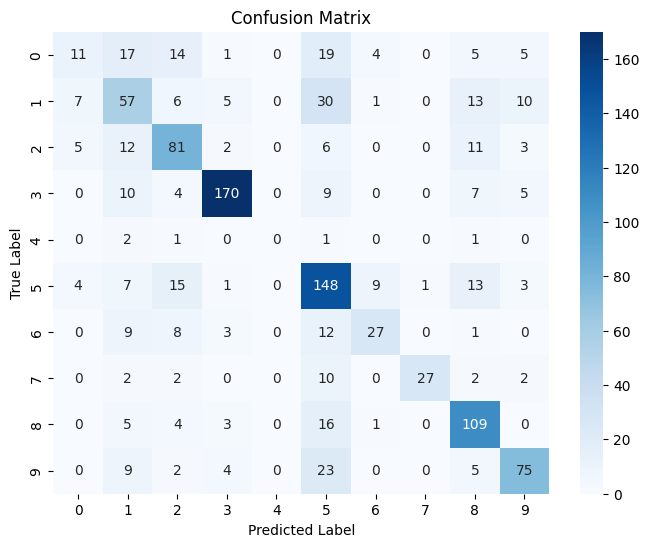

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

# Step 2: Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types to use
    'gamma': ['scale', 'auto'],  # Kernel coefficient (only used for rbf, poly, sigmoid kernels)
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

# Step 3: Create an SVC model
svc = SVC()

# Step 4: Apply GridSearchCV for hyperparameter tuning with 3-fold cross-validation
grid_search = GridSearchCV(
    svc,
    param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=1,  # Use all available CPU cores for parallel processing
    verbose=10,  # Print progress during grid search
    scoring='accuracy'  # Accuracy as the evaluation metric
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Step 5: Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Step 6: Evaluate the best model on the validation/test set
best_model = grid_search.best_estimator_

# Assuming `val_df` has the column 'cleaned_captions' and 'label_encoded'
X_val_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_val = val_df['label_encoded']

# Predict the labels on the validation set
y_pred = best_model.predict(X_val_tfidf)

# Step 7: Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 8: Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.best_estimator_.classes_, yticklabels=grid_search.best_estimator_.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218689
[LightGBM] [Info] Number of data points in the train set: 2192, number of used features: 4542
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

Accuracy: 0.6321

Classification Report:
                      precision    recall  f1-score   support

                 art       0.17      0.08      0.11        38
       entertainment       0.39      0.31      0.34        65
             fashion       0.51      0.65      0.57        60
                food       0.83      0.91      0.87       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.58      0.74      0.65       100
    mom and children       0.76      0.43      0.55        30
              sports       0.78      0.61      0.68        23
                tech       0.72      0.72      0.72        69
              travel       0.69      0.69      0.69        59

            accuracy                           0.63       549
           macro avg       0.54      0.51      0.52       549
        weighted avg       0.61      0.63      0.61       549



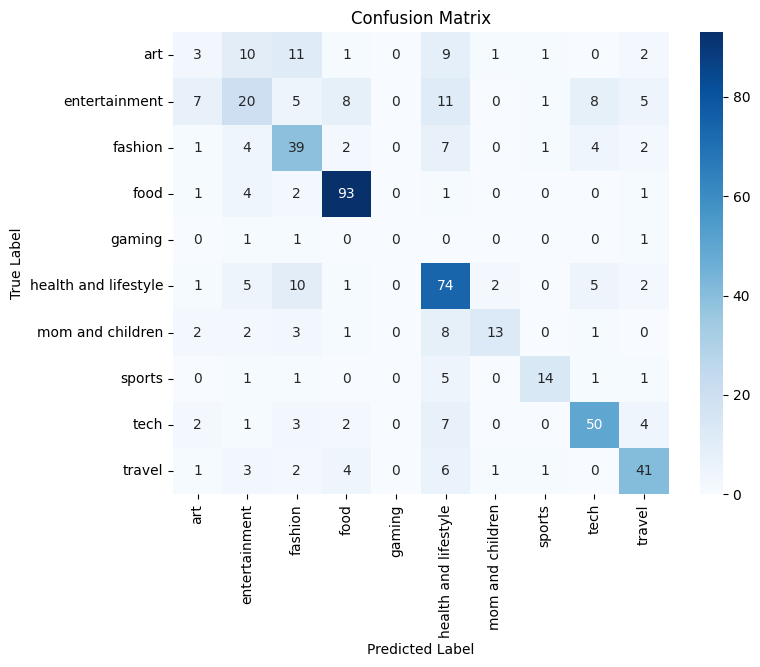


Top 10 Important Features:
     Feature  Importance
1357      ed         343
1836     gün         323
2119      in         229
2692  lezzet         229
4485     yap         227
4568    yeni         226
310       al         221
2287    kalp         214
361       an         200
4802   çocuk         190


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume train_data_df is loaded ---

# Step 1: Vectorize `cleaned_captions` with TF-IDF
tfidf = TfidfVectorizer(max_df=0.85, min_df=1, max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(train_data_df['cleaned_captions'].astype(str))

# Step 2: Extract labels
y = train_data_df['label']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Train LightGBM Classifier
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    learning_rate=0.1,
    num_leaves=31
)
lgb_clf.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = lgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Feature Importance
feature_importances = lgb_clf.feature_importances_
tfidf_feature_names = tfidf.get_feature_names_out()

# Sort by importance
importance_df = pd.DataFrame({
    "Feature": tfidf_feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.75, 0.85],
    'tfidf__min_df': [1],
    'tfidf__max_features': [ 5000],
    'tfidf__ngram_range': [(1, 2)],
}

# Create a pipeline with TF-IDF and the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(verbose=True)),  # Increase verbosity for SVC
])

# Create the GridSearchCV object with verbosity
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric (or choose another)
    n_jobs=1,  # Use all available CPU cores for parallel processing
    verbose=10  # Verbose output to see progress during the grid search
)

# Fit the GridSearchCV object to the training data
grid_search.fit(corpus_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set using the best model found by GridSearchCV
best_model = grid_search.best_estimator_
accuracy = best_model.score(corpus_test, y_test)
print("Test set accuracy:", accuracy)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[LibSVM][CV 1/3; 1/6] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.627 total time=  34.8s
[CV 2/3; 1/6] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[LibSVM][CV 2/3; 1/6] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.640 total time=  28.8s
[CV 3/3; 1/6] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2)
[LibSVM][CV 3/3; 1/6] END tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.657 total time=  28.7s
[CV 1/3; 2/6] START tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 3)
[LibSVM][CV 1/3; 2/6] END tfidf__max_df=0.75, tfidf__max_fea

NameError: name 'y_test' is not defined

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode 'category_name' using Label Encoding
label_encoder = LabelEncoder()
#train_profile_df['category_name'] = label_encoder.fit_transform(train_profile_df['category_name'])

# Encode 'category_enum' using Label Encoding
train_data_df['label_encoded']= label_encoder.fit_transform(train_data_df['label'])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    train_data_df,
    test_size=0.3,  # 20% for validation
    stratify=train_data_df['label_encoded'],  # Preserve label distribution
    random_state=42  # For reproducibility
)

# Print the size of each split
print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")

# Check distribution of labels in each split
print("Training label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))

Training set size: 1918
Validation set size: 823
Training label distribution:
label
food                    0.186653
health and lifestyle    0.183003
tech                    0.126173
entertainment           0.117831
fashion                 0.108968
travel                  0.107404
art                     0.069864
mom and children        0.054223
sports                  0.041189
gaming                  0.004692
Name: proportion, dtype: float64

Validation label distribution:
label
food                    0.185905
health and lifestyle    0.183475
tech                    0.126367
entertainment           0.117861
fashion                 0.109356
travel                  0.106926
art                     0.069259
mom and children        0.054678
sports                  0.041312
gaming                  0.004860
Name: proportion, dtype: float64


In [ ]:
print(train_df.isnull().sum())  # Check for missing values in train
print(val_df.isnull().sum())    # Check for missing values in val


username            0
cleaned_captions    0
label               0
label_encoded       0
dtype: int64
username            0
cleaned_captions    0
label               0
label_encoded       0
dtype: int64


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 1/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.330 total time=   8.6s
[CV 2/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 2/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.330 total time=   7.9s
[CV 3/3; 1/24] START C=0.1, class_weight=None, gamma=scale, kernel=linear.......
[CV 3/3; 1/24] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.349 total time=   7.4s
[CV 1/3; 2/24] START C=0.1, class_weight=None, gamma=scale, kernel=rbf..........
[CV 1/3; 2/24] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.188 total time=   8.9s
[CV 2/3; 2/24] START C=0.1, class_weight=None, gamma=scale, kernel=rbf..........
[CV 2/3; 2/24] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.186 total time=   9.2s
[CV 3/3; 2/24] 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


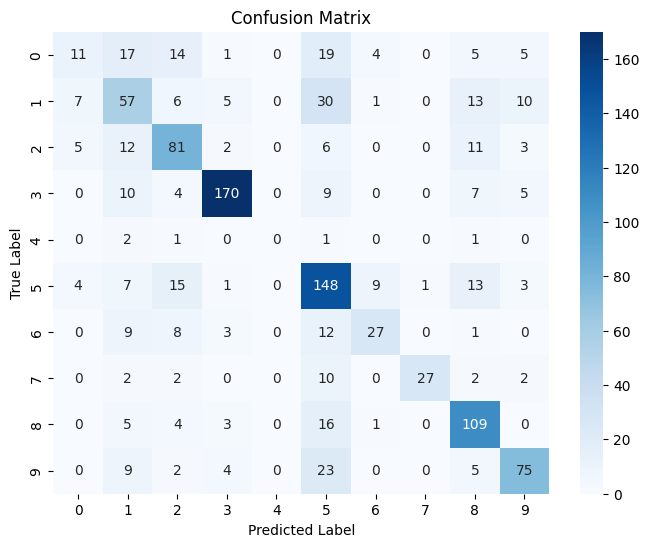

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

# Step 2: Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types to use
    'gamma': ['scale', 'auto'],  # Kernel coefficient (only used for rbf, poly, sigmoid kernels)
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

# Step 3: Create an SVC model
svc = SVC()

# Step 4: Apply GridSearchCV for hyperparameter tuning with 3-fold cross-validation
grid_search = GridSearchCV(
    svc,
    param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=1,  # Use all available CPU cores for parallel processing
    verbose=10,  # Print progress during grid search
    scoring='accuracy'  # Accuracy as the evaluation metric
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Step 5: Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Step 6: Evaluate the best model on the validation/test set
best_model = grid_search.best_estimator_

# Assuming `val_df` has the column 'cleaned_captions' and 'label_encoded'
X_val_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_val = val_df['label_encoded']

# Predict the labels on the validation set
y_pred = best_model.predict(X_val_tfidf)

# Step 7: Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 8: Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.best_estimator_.classes_, yticklabels=grid_search.best_estimator_.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Validation Accuracy: 0.6476

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.28      0.34        57
           1       0.55      0.44      0.49        97
           2       0.54      0.62      0.58        90
           3       0.88      0.86      0.87       153
           4       0.00      0.00      0.00         4
           5       0.67      0.61      0.64       151
           6       0.48      0.49      0.48        45
           7       0.63      0.76      0.69        34
           8       0.65      0.83      0.73       104
           9       0.64      0.69      0.66        88

    accuracy                           0.65       823
   macro avg       0.55      0.56      0.55       823
weighted avg       0.64      0.65      0.64       823



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


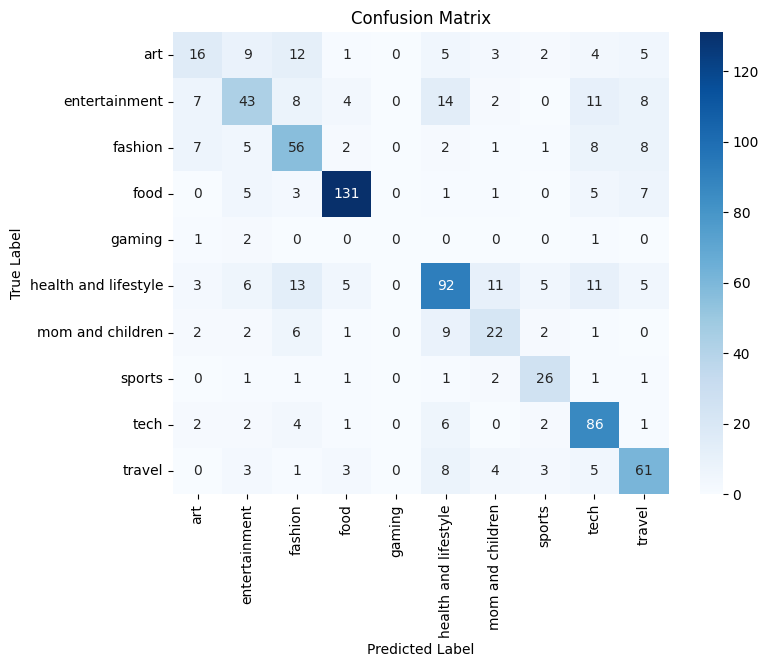

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3; 1/48] START C=0.1, class_weight=None, max_iter=100, solver=liblinear...
[CV 1/3; 1/48] END C=0.1, class_weight=None, max_iter=100, solver=liblinear;, score=0.381 total time=   0.2s
[CV 2/3; 1/48] START C=0.1, class_weight=None, max_iter=100, solver=liblinear...
[CV 2/3; 1/48] END C=0.1, class_weight=None, max_iter=100, solver=liblinear;, score=0.362 total time=   0.2s
[CV 3/3; 1/48] START C=0.1, class_weight=None, max_iter=100, solver=liblinear...
[CV 3/3; 1/48] END C=0.1, class_weight=None, max_iter=100, solver=liblinear;, score=0.382 total time=   0.2s
[CV 1/3; 2/48] START C=0.1, class_weight=None, max_iter=100, solver=saga........
[CV 1/3; 2/48] END C=0.1, class_weight=None, max_iter=100, solver=saga;, score=0.386 total time=   0.3s
[CV 2/3; 2/48] START C=0.1, class_weight=None, max_iter=100, solver=saga........
[CV 2/3; 2/48] END C=0.1, class_weight=None, max_iter=100, solver=saga;, score=0.363 total time=   0.4

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 10/48] END C=0.1, class_weight=balanced, max_iter=100, solver=saga;, score=0.559 total time=   1.9s
[CV 2/3; 10/48] START C=0.1, class_weight=balanced, max_iter=100, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 10/48] END C=0.1, class_weight=balanced, max_iter=100, solver=saga;, score=0.574 total time=   1.9s
[CV 3/3; 10/48] START C=0.1, class_weight=balanced, max_iter=100, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 10/48] END C=0.1, class_weight=balanced, max_iter=100, solver=saga;, score=0.590 total time=   1.9s
[CV 1/3; 11/48] START C=0.1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 1/3; 11/48] END C=0.1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.581 total time=   0.2s
[CV 2/3; 11/48] START C=0.1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 2/3; 11/48] END C=0.1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.588 total time=   0.2s
[CV 3/3; 11/48] START C=0.1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 3/3; 11/48] END C=0.1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.598 total time=   0.2s
[CV 1/3; 12/48] START C=0.1, class_weight=balanced, max_iter=200, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 12/48] END C=0.1, class_weight=balanced, max_iter=200, solver=saga;, score=0.575 total time=   4.1s
[CV 2/3; 12/48] START C=0.1, class_weight=balanced, max_iter=200, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 12/48] END C=0.1, class_weight=balanced, max_iter=200, solver=saga;, score=0.595 total time=   5.3s
[CV 3/3; 12/48] START C=0.1, class_weight=balanced, max_iter=200, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 12/48] END C=0.1, class_weight=balanced, max_iter=200, solver=saga;, score=0.584 total time=   3.8s
[CV 1/3; 13/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 1/3; 13/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.581 total time=   0.2s
[CV 2/3; 13/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 2/3; 13/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.588 total time=   0.2s
[CV 3/3; 13/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 3/3; 13/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.598 total time=   0.2s
[CV 1/3; 14/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 14/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.572 total time=  21.4s
[CV 2/3; 14/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 14/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.584 total time=  22.0s
[CV 3/3; 14/48] START C=0.1, class_weight=balanced, max_iter=1000, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 14/48] END C=0.1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.593 total time=  20.8s
[CV 1/3; 15/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 1/3; 15/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.581 total time=   0.2s
[CV 2/3; 15/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 2/3; 15/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.588 total time=   0.2s
[CV 3/3; 15/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 3/3; 15/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.598 total time=   0.2s
[CV 1/3; 16/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 16/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.573 total time=  32.9s
[CV 2/3; 16/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 16/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.587 total time=  35.0s
[CV 3/3; 16/48] START C=0.1, class_weight=balanced, max_iter=1500, solver=saga..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 16/48] END C=0.1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.588 total time=  32.2s
[CV 1/3; 17/48] START C=1, class_weight=None, max_iter=100, solver=liblinear....
[CV 1/3; 17/48] END C=1, class_weight=None, max_iter=100, solver=liblinear;, score=0.622 total time=   0.3s
[CV 2/3; 17/48] START C=1, class_weight=None, max_iter=100, solver=liblinear....
[CV 2/3; 17/48] END C=1, class_weight=None, max_iter=100, solver=liblinear;, score=0.638 total time=   0.3s
[CV 3/3; 17/48] START C=1, class_weight=None, max_iter=100, solver=liblinear....
[CV 3/3; 17/48] END C=1, class_weight=None, max_iter=100, solver=liblinear;, score=0.615 total time=   0.3s
[CV 1/3; 18/48] START C=1, class_weight=None, max_iter=100, solver=saga.........
[CV 1/3; 18/48] END C=1, class_weight=None, max_iter=100, solver=saga;, score=0.634 total time=   0.9s
[CV 2/3; 18/48] START C=1, class_weight=None, max_iter=100, solver=saga.........
[CV 2/3; 18/48] END C=1, class_weight=None, max_iter=100, 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 26/48] END C=1, class_weight=balanced, max_iter=100, solver=saga;, score=0.613 total time=   1.9s
[CV 2/3; 26/48] START C=1, class_weight=balanced, max_iter=100, solver=saga.....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 26/48] END C=1, class_weight=balanced, max_iter=100, solver=saga;, score=0.620 total time=   2.1s
[CV 3/3; 26/48] START C=1, class_weight=balanced, max_iter=100, solver=saga.....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 26/48] END C=1, class_weight=balanced, max_iter=100, solver=saga;, score=0.623 total time=   3.1s
[CV 1/3; 27/48] START C=1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 1/3; 27/48] END C=1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.652 total time=   0.4s
[CV 2/3; 27/48] START C=1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 2/3; 27/48] END C=1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.681 total time=   0.4s
[CV 3/3; 27/48] START C=1, class_weight=balanced, max_iter=200, solver=liblinear
[CV 3/3; 27/48] END C=1, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.653 total time=   0.4s
[CV 1/3; 28/48] START C=1, class_weight=balanced, max_iter=200, solver=saga.....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 28/48] END C=1, class_weight=balanced, max_iter=200, solver=saga;, score=0.633 total time=   3.8s
[CV 2/3; 28/48] START C=1, class_weight=balanced, max_iter=200, solver=saga.....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 28/48] END C=1, class_weight=balanced, max_iter=200, solver=saga;, score=0.637 total time=   3.7s
[CV 3/3; 28/48] START C=1, class_weight=balanced, max_iter=200, solver=saga.....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 28/48] END C=1, class_weight=balanced, max_iter=200, solver=saga;, score=0.607 total time=   4.8s
[CV 1/3; 29/48] START C=1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 1/3; 29/48] END C=1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.652 total time=   0.4s
[CV 2/3; 29/48] START C=1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 2/3; 29/48] END C=1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.681 total time=   0.4s
[CV 3/3; 29/48] START C=1, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 3/3; 29/48] END C=1, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.653 total time=   0.5s
[CV 1/3; 30/48] START C=1, class_weight=balanced, max_iter=1000, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 30/48] END C=1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.630 total time=  21.1s
[CV 2/3; 30/48] START C=1, class_weight=balanced, max_iter=1000, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 30/48] END C=1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.656 total time=  20.8s
[CV 3/3; 30/48] START C=1, class_weight=balanced, max_iter=1000, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 30/48] END C=1, class_weight=balanced, max_iter=1000, solver=saga;, score=0.643 total time=  22.6s
[CV 1/3; 31/48] START C=1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 1/3; 31/48] END C=1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.652 total time=   0.3s
[CV 2/3; 31/48] START C=1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 2/3; 31/48] END C=1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.681 total time=   0.3s
[CV 3/3; 31/48] START C=1, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 3/3; 31/48] END C=1, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.653 total time=   0.3s
[CV 1/3; 32/48] START C=1, class_weight=balanced, max_iter=1500, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 32/48] END C=1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.639 total time=  31.9s
[CV 2/3; 32/48] START C=1, class_weight=balanced, max_iter=1500, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 32/48] END C=1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.673 total time=  31.9s
[CV 3/3; 32/48] START C=1, class_weight=balanced, max_iter=1500, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 32/48] END C=1, class_weight=balanced, max_iter=1500, solver=saga;, score=0.623 total time=  32.3s
[CV 1/3; 33/48] START C=10, class_weight=None, max_iter=100, solver=liblinear...
[CV 1/3; 33/48] END C=10, class_weight=None, max_iter=100, solver=liblinear;, score=0.650 total time=   0.5s
[CV 2/3; 33/48] START C=10, class_weight=None, max_iter=100, solver=liblinear...
[CV 2/3; 33/48] END C=10, class_weight=None, max_iter=100, solver=liblinear;, score=0.689 total time=   0.7s
[CV 3/3; 33/48] START C=10, class_weight=None, max_iter=100, solver=liblinear...
[CV 3/3; 33/48] END C=10, class_weight=None, max_iter=100, solver=liblinear;, score=0.648 total time=   0.6s
[CV 1/3; 34/48] START C=10, class_weight=None, max_iter=100, solver=saga........


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 34/48] END C=10, class_weight=None, max_iter=100, solver=saga;, score=0.656 total time=   3.1s
[CV 2/3; 34/48] START C=10, class_weight=None, max_iter=100, solver=saga........


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 34/48] END C=10, class_weight=None, max_iter=100, solver=saga;, score=0.695 total time=   3.2s
[CV 3/3; 34/48] START C=10, class_weight=None, max_iter=100, solver=saga........


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 34/48] END C=10, class_weight=None, max_iter=100, solver=saga;, score=0.642 total time=   2.9s
[CV 1/3; 35/48] START C=10, class_weight=None, max_iter=200, solver=liblinear...
[CV 1/3; 35/48] END C=10, class_weight=None, max_iter=200, solver=liblinear;, score=0.650 total time=   0.5s
[CV 2/3; 35/48] START C=10, class_weight=None, max_iter=200, solver=liblinear...
[CV 2/3; 35/48] END C=10, class_weight=None, max_iter=200, solver=liblinear;, score=0.689 total time=   0.5s
[CV 3/3; 35/48] START C=10, class_weight=None, max_iter=200, solver=liblinear...
[CV 3/3; 35/48] END C=10, class_weight=None, max_iter=200, solver=liblinear;, score=0.648 total time=   0.5s
[CV 1/3; 36/48] START C=10, class_weight=None, max_iter=200, solver=saga........
[CV 1/3; 36/48] END C=10, class_weight=None, max_iter=200, solver=saga;, score=0.656 total time=   3.4s
[CV 2/3; 36/48] START C=10, class_weight=None, max_iter=200, solver=saga........
[CV 2/3; 36/48] END C=10, class_weight=None, max_iter=200, s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 42/48] END C=10, class_weight=balanced, max_iter=100, solver=saga;, score=0.633 total time=   2.1s
[CV 2/3; 42/48] START C=10, class_weight=balanced, max_iter=100, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 42/48] END C=10, class_weight=balanced, max_iter=100, solver=saga;, score=0.703 total time=   1.9s
[CV 3/3; 42/48] START C=10, class_weight=balanced, max_iter=100, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 42/48] END C=10, class_weight=balanced, max_iter=100, solver=saga;, score=0.664 total time=   1.9s
[CV 1/3; 43/48] START C=10, class_weight=balanced, max_iter=200, solver=liblinear
[CV 1/3; 43/48] END C=10, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.659 total time=   0.5s
[CV 2/3; 43/48] START C=10, class_weight=balanced, max_iter=200, solver=liblinear
[CV 2/3; 43/48] END C=10, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.704 total time=   0.5s
[CV 3/3; 43/48] START C=10, class_weight=balanced, max_iter=200, solver=liblinear
[CV 3/3; 43/48] END C=10, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.667 total time=   0.5s
[CV 1/3; 44/48] START C=10, class_weight=balanced, max_iter=200, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 44/48] END C=10, class_weight=balanced, max_iter=200, solver=saga;, score=0.617 total time=   4.1s
[CV 2/3; 44/48] START C=10, class_weight=balanced, max_iter=200, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 44/48] END C=10, class_weight=balanced, max_iter=200, solver=saga;, score=0.704 total time=   5.4s
[CV 3/3; 44/48] START C=10, class_weight=balanced, max_iter=200, solver=saga....


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 44/48] END C=10, class_weight=balanced, max_iter=200, solver=saga;, score=0.662 total time=   3.8s
[CV 1/3; 45/48] START C=10, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 1/3; 45/48] END C=10, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.659 total time=   0.5s
[CV 2/3; 45/48] START C=10, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 2/3; 45/48] END C=10, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.704 total time=   0.5s
[CV 3/3; 45/48] START C=10, class_weight=balanced, max_iter=1000, solver=liblinear
[CV 3/3; 45/48] END C=10, class_weight=balanced, max_iter=1000, solver=liblinear;, score=0.667 total time=   0.5s
[CV 1/3; 46/48] START C=10, class_weight=balanced, max_iter=1000, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 46/48] END C=10, class_weight=balanced, max_iter=1000, solver=saga;, score=0.637 total time=  21.9s
[CV 2/3; 46/48] START C=10, class_weight=balanced, max_iter=1000, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 46/48] END C=10, class_weight=balanced, max_iter=1000, solver=saga;, score=0.703 total time=  21.2s
[CV 3/3; 46/48] START C=10, class_weight=balanced, max_iter=1000, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 46/48] END C=10, class_weight=balanced, max_iter=1000, solver=saga;, score=0.664 total time=  21.1s
[CV 1/3; 47/48] START C=10, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 1/3; 47/48] END C=10, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.659 total time=   0.7s
[CV 2/3; 47/48] START C=10, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 2/3; 47/48] END C=10, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.704 total time=   0.7s
[CV 3/3; 47/48] START C=10, class_weight=balanced, max_iter=1500, solver=liblinear
[CV 3/3; 47/48] END C=10, class_weight=balanced, max_iter=1500, solver=liblinear;, score=0.667 total time=   0.7s
[CV 1/3; 48/48] START C=10, class_weight=balanced, max_iter=1500, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 48/48] END C=10, class_weight=balanced, max_iter=1500, solver=saga;, score=0.613 total time=  32.9s
[CV 2/3; 48/48] START C=10, class_weight=balanced, max_iter=1500, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 48/48] END C=10, class_weight=balanced, max_iter=1500, solver=saga;, score=0.704 total time=  32.2s
[CV 3/3; 48/48] START C=10, class_weight=balanced, max_iter=1500, solver=saga...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 48/48] END C=10, class_weight=balanced, max_iter=1500, solver=saga;, score=0.662 total time=  32.3s
Best parameters from GridSearchCV: {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear'}
Best cross-validation score from GridSearchCV: 0.6767556729264476
Validation Accuracy of the best model: 0.6403


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

X_test_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_test = val_df['label_encoded']

# Step 2: Define the Logistic Regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

# Fit the Logistic Regression model
clf.fit(X_train_tfidf, y_train)

# Step 3: Evaluate on the validation/test set
y_pred = clf.predict(X_test_tfidf)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Hyperparameter tuning (Grid Search)
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to choose from
    'max_iter': [100, 200, 1000,1500],  # Number of iterations
    'class_weight': [None, 'balanced'],  # Handling class imbalance
}

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=1,  # Use all available cores for parallel computation
    verbose=10  # Verbose output
)

# Fit the GridSearchCV object
grid_search.fit(X_train_tfidf, y_train)

# Print best parameters and best score
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best cross-validation score from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Calculate accuracy for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Validation Accuracy of the best model: {accuracy_best:.4f}")


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


Validation Accuracy: 0.6343

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.11      0.18        57
           1       0.45      0.46      0.46        97
           2       0.58      0.68      0.63        90
           3       0.78      0.90      0.84       153
           4       0.00      0.00      0.00         4
           5       0.56      0.72      0.63       151
           6       0.71      0.33      0.45        45
           7       0.84      0.47      0.60        34
           8       0.68      0.76      0.72       104
           9       0.65      0.61      0.63        88

    accuracy                           0.63       823
   macro avg       0.59      0.50      0.51       823
weighted avg       0.64      0.63      0.61       823



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


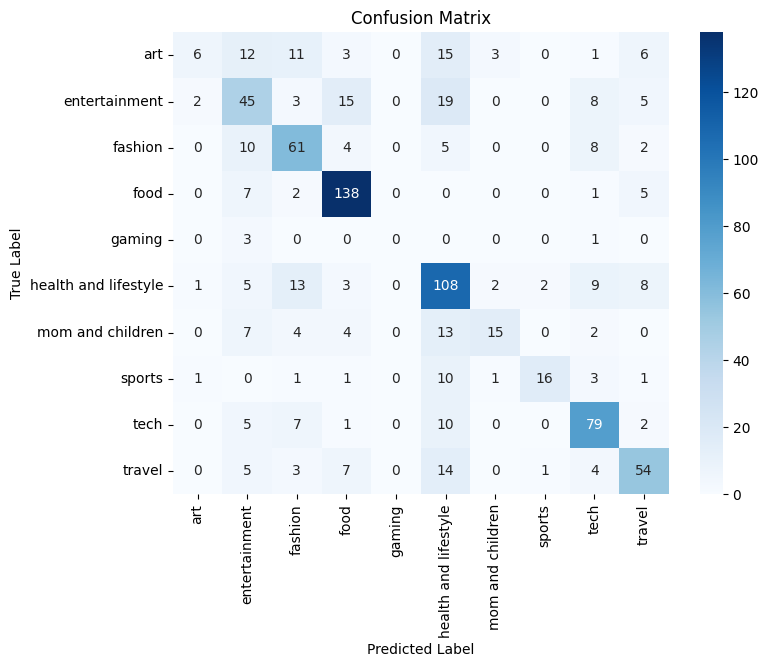

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV 1/3; 1/540] START class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/3; 1/540] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 1/540] START class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/3; 1/540] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 1/540] START class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/3; 1/540] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_sa

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters from GridSearchCV: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation score from GridSearchCV: 0.6308628390714659
Validation Accuracy of the best model: 0.6428


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

X_test_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_test = val_df['label_encoded']

# Step 2: Define the Random Forest Classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the Random Forest model
clf.fit(X_train_tfidf, y_train)

# Step 3: Evaluate on the validation/test set
y_pred = clf.predict(X_test_tfidf)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Hyperparameter tuning (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 30, 50,None],  # Depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'class_weight': ['balanced'],  # Handling class imbalance
    'criterion': ['gini', 'entropy']  # Measure to use for impurity calculation
}

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=1,  # Use all available cores for parallel computation
    verbose=10  # Verbose output
)

# Fit the GridSearchCV object
grid_search.fit(X_train_tfidf, y_train)

# Print best parameters and best score
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best cross-validation score from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Calculate accuracy for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Validation Accuracy of the best model: {accuracy_best:.4f}")


Validation Accuracy: 0.6343

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.11      0.18        57
           1       0.45      0.46      0.46        97
           2       0.58      0.68      0.63        90
           3       0.78      0.90      0.84       153
           4       0.00      0.00      0.00         4
           5       0.56      0.72      0.63       151
           6       0.71      0.33      0.45        45
           7       0.84      0.47      0.60        34
           8       0.68      0.76      0.72       104
           9       0.65      0.61      0.63        88

    accuracy                           0.63       823
   macro avg       0.59      0.50      0.51       823
weighted avg       0.64      0.63      0.61       823



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


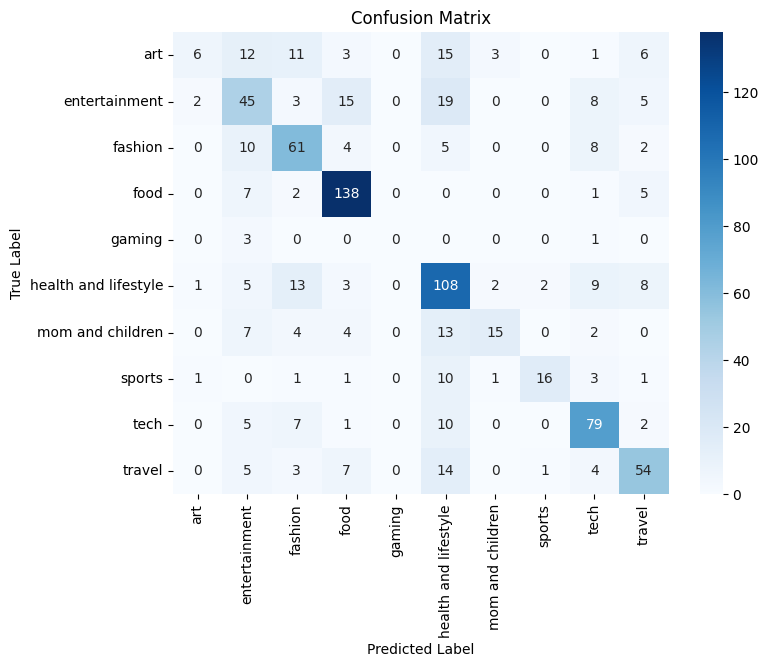

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 1/3; 1/6] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.584 total time=   6.4s
[CV 2/3; 1/6] START class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 2/3; 1/6] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.592 total time=   4.9s
[CV 3/3; 1/6] START class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 3/3; 1/6] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

X_test_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_test = val_df['label_encoded']

# Step 2: Define the Random Forest Classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the Random Forest model
clf.fit(X_train_tfidf, y_train)

# Step 3: Evaluate on the validation/test set
y_pred = clf.predict(X_test_tfidf)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Hyperparameter tuning (Grid Search)
param_grid = {
    'n_estimators': [500,750],  # Number of trees
    'max_depth': [10, 20, 30],  # Depth of each tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [ 2],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt'],  # Number of features to consider at each split
    'class_weight': ['balanced'],  # Handling class imbalance
    'criterion': ['gini']  # Measure to use for impurity calculation
}

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=1,  # Use all available cores for parallel computation
    verbose=10  # Verbose output
)

# Fit the GridSearchCV object
grid_search.fit(X_train_tfidf, y_train)

# Print best parameters and best score
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best cross-validation score from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Calculate accuracy for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Validation Accuracy of the best model: {accuracy_best:.4f}")


0:	learn: 2.2047720	total: 6.68s	remaining: 1h 51m 11s
20:	learn: 1.6403499	total: 1m 40s	remaining: 1h 18m 13s
40:	learn: 1.4238217	total: 2m 53s	remaining: 1h 7m 29s
60:	learn: 1.2803499	total: 4m 11s	remaining: 1h 4m 28s
80:	learn: 1.1706158	total: 5m 20s	remaining: 1h 41s
100:	learn: 1.0537056	total: 6m 27s	remaining: 57m 30s
120:	learn: 0.9744269	total: 7m 38s	remaining: 55m 28s
140:	learn: 0.9176821	total: 8m 46s	remaining: 53m 25s
160:	learn: 0.8751799	total: 9m 52s	remaining: 51m 29s
180:	learn: 0.8345276	total: 11m 1s	remaining: 49m 51s
200:	learn: 0.7992662	total: 12m 11s	remaining: 48m 26s
220:	learn: 0.7742876	total: 13m 18s	remaining: 46m 53s
240:	learn: 0.7503883	total: 14m 27s	remaining: 45m 30s
260:	learn: 0.7255238	total: 15m 33s	remaining: 44m 4s
280:	learn: 0.7064929	total: 16m 42s	remaining: 42m 45s
300:	learn: 0.6898579	total: 17m 51s	remaining: 41m 27s
320:	learn: 0.6740836	total: 19m 2s	remaining: 40m 15s
340:	learn: 0.6573645	total: 20m 9s	remaining: 38m 56s
360

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


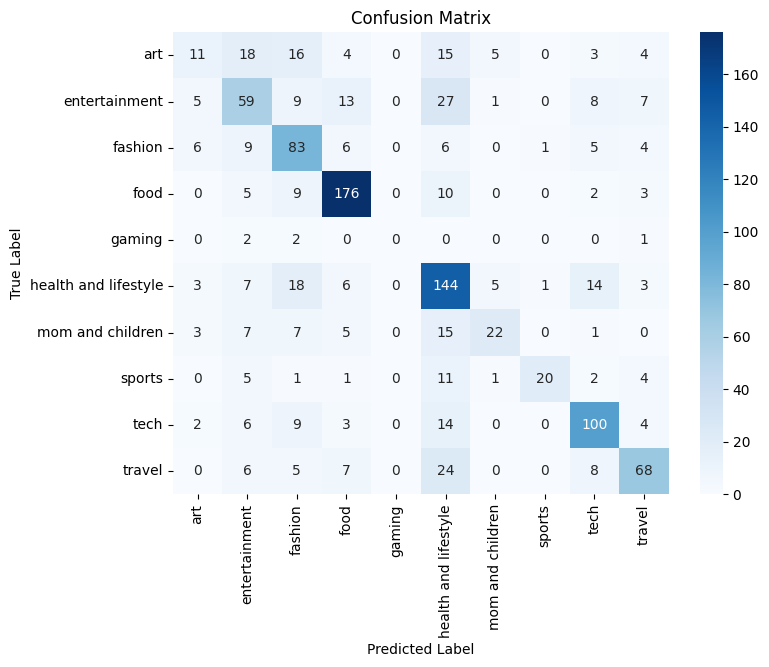

In [ ]:
import catboost
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

X_test_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_test = val_df['label_encoded']

# Step 2: Define the CatBoost model
clf = CatBoostClassifier(
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=6,  # Maximum depth of the tree
    cat_features=[],  # Specify categorical features if any, empty list here
    verbose=20  # Print progress every 100 iterations
)

# Fit the CatBoost model
clf.fit(X_train_tfidf, y_train)

# Step 3: Evaluate on the validation/test set
y_pred = clf.predict(X_test_tfidf)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Iteration 1, loss = 2.22920945
Iteration 2, loss = 1.94884012
Iteration 3, loss = 1.63058249
Iteration 4, loss = 1.32569083
Iteration 5, loss = 1.06366592
Iteration 6, loss = 0.85264546
Iteration 7, loss = 0.69214469
Iteration 8, loss = 0.56978498
Iteration 9, loss = 0.47586883
Iteration 10, loss = 0.40215483
Iteration 11, loss = 0.34246819
Iteration 12, loss = 0.29459716
Iteration 13, loss = 0.25454754
Iteration 14, loss = 0.22166831
Iteration 15, loss = 0.19413964
Iteration 16, loss = 0.17076432
Iteration 17, loss = 0.15138782
Iteration 18, loss = 0.13493247
Iteration 19, loss = 0.12104693
Iteration 20, loss = 0.10922356
Iteration 21, loss = 0.09905338
Iteration 22, loss = 0.09053581
Iteration 23, loss = 0.08316633
Iteration 24, loss = 0.07664040
Iteration 25, loss = 0.07103048
Iteration 26, loss = 0.06613345
Iteration 27, loss = 0.06173590
Iteration 28, loss = 0.05804449
Iteration 29, loss = 0.05464102
Iteration 30, loss = 0.05169349
Iteration 31, loss = 0.04908469
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


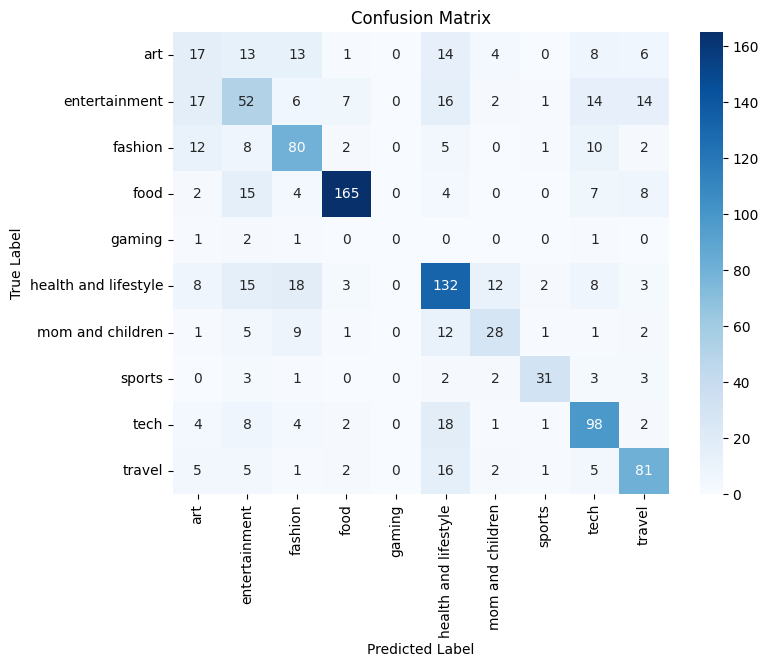

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

# Step 2: Apply SMOTE to handle class imbalance (oversample minority class)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Step 3: Train an MLPClassifier model
clf = MLPClassifier(
    hidden_layer_sizes=(100,),  # You can adjust the number of layers and neurons
    activation='relu',  # ReLU activation function
    solver='adam',  # Optimizer
    max_iter=300,  # Maximum iterations
    verbose=True  # For verbosity during training
)

# Fit the classifier on the resampled data
clf.fit(X_train_resampled, y_train_resampled)

# Step 4: Evaluate on a validation/test set
# Assuming `val_df` has the same structure
X_val_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_val = val_df['label_encoded']

# Predict the labels on the validation set
y_pred = clf.predict(X_val_tfidf)

# Step 5: Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 6: Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

# Step 2: Train a Multi-Layer Perceptron (MLP) model
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', verbose=True)

# Fit the classifier
clf.fit(X_train_tfidf, y_train)

# Step 3: Evaluate on a validation/test set
# Assuming `val_df` has the same structure
X_val_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_val = val_df['label_encoded']

# Predict the labels on the validation set
y_pred = clf.predict(X_val_tfidf)

# Step 4: Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Iteration 1, loss = 2.25730842
Iteration 2, loss = 2.08892365
Iteration 3, loss = 1.90242427
Iteration 4, loss = 1.71100233
Iteration 5, loss = 1.52859277
Iteration 6, loss = 1.35413625
Iteration 7, loss = 1.20061150
Iteration 8, loss = 1.06472460
Iteration 9, loss = 0.94888346
Iteration 10, loss = 0.84787255
Iteration 11, loss = 0.76064039
Iteration 12, loss = 0.68361618
Iteration 13, loss = 0.61602913
Iteration 14, loss = 0.55605491
Iteration 15, loss = 0.50110802
Iteration 16, loss = 0.45293752
Iteration 17, loss = 0.40891635
Iteration 18, loss = 0.37026077
Iteration 19, loss = 0.33421005
Iteration 20, loss = 0.30246028
Iteration 21, loss = 0.27367342
Iteration 22, loss = 0.24799654
Iteration 23, loss = 0.22529016
Iteration 24, loss = 0.20460835
Iteration 25, loss = 0.18618599
Iteration 26, loss = 0.16981595
Iteration 27, loss = 0.15514504
Iteration 28, loss = 0.14227164
Iteration 29, loss = 0.13084975
Iteration 30, loss = 0.12004040
Iteration 31, loss = 0.11105818
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.22      0.24        76
           1       0.41      0.40      0.41       129
           2       0.58      0.67      0.62       120
           3       0.90      0.80      0.85       205
           4       0.00      0.00      0.00         5
           5       0.60      0.66      0.63       201
           6       0.55      0.47      0.50        60
           7       0.82      0.69      0.75        45
           8       0.63      0.71      0.67       138
           9       0.67      0.69      0.68       118

    accuracy                           0.62      1097
   macro avg       0.54      0.53      0.53      1097
weighted avg       0.62      0.62      0.62      1097



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


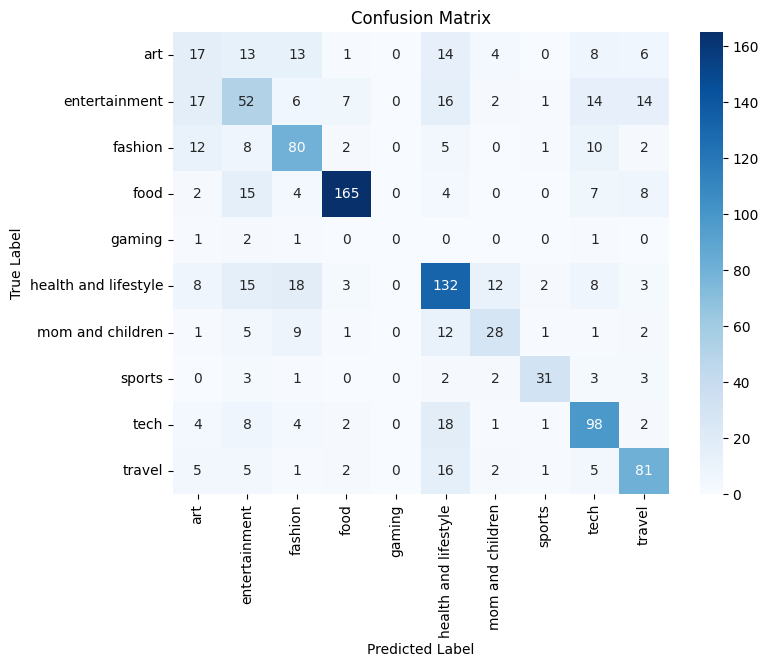

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
# Step 5: Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 6: Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

[LibSVM]Validation Accuracy: 0.6399

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.28      0.30        76
           1       0.43      0.46      0.45       129
           2       0.60      0.68      0.64       120
           3       0.90      0.82      0.86       205
           4       0.00      0.00      0.00         5
           5       0.60      0.64      0.62       201
           6       0.56      0.48      0.52        60
           7       0.72      0.62      0.67        45
           8       0.65      0.77      0.71       138
           9       0.75      0.69      0.72       118

    accuracy                           0.64      1097
   macro avg       0.55      0.54      0.55      1097
weighted avg       0.64      0.64      0.64      1097



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


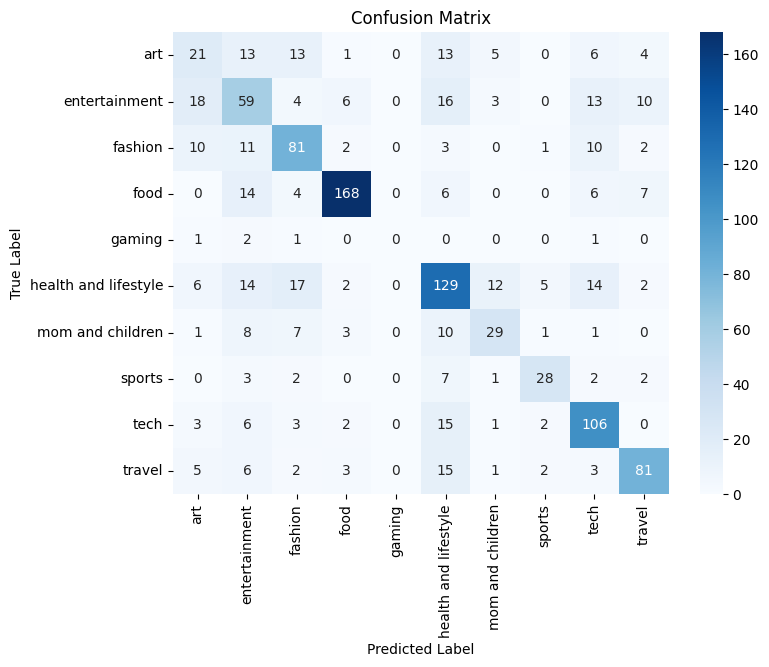

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Step 1: Vectorize the training data using the given parameters
tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=1,
    max_features=5000,
    ngram_range=(1, 2)
)

# Assuming `train_df` has the column 'cleaned_captions' and 'label_encoded'
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_captions'])
y_train = train_df['label_encoded']

# Step 2: Apply SMOTE to handle class imbalance (oversample minority class)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Step 3: Train an SVC model
clf = SVC(kernel='linear', C=1.0, verbose=True)  # Linear kernel, C=1.0 for regularization

# Fit the classifier on the resampled data
clf.fit(X_train_resampled, y_train_resampled)

# Step 4: Evaluate on a validation/test set
# Assuming `val_df` has the same structure
X_val_tfidf = tfidf.transform(val_df['cleaned_captions'])
y_val = val_df['label_encoded']

# Predict the labels on the validation set
y_pred = clf.predict(X_val_tfidf)

# Step 5: Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Optional: Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 6: Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.75, 0.85],
    'tfidf__min_df': [1],
    'tfidf__max_features': [5000],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 1)],
    'clf__learning_rate': [0.1, 0.01],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
}

# Create a pipeline with TF-IDF and XGBoost classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))  # Using XGBoost classifier
])

# Create the GridSearchCV object with verbosity
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=1,  # Use all available CPU cores for parallel processing
    verbose=10  # Verbose output to see progress during the grid search
)

# Fit the GridSearchCV object to the training data
grid_search.fit(corpus_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set using the best model found by GridSearchCV
best_model = grid_search.best_estimator_
accuracy = best_model.score(corpus_test, y_test)
print("Test set accuracy:", accuracy)


# ROUND 1 & ROUND 2






In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use a multilingual RoBERTa model, or replace with a Turkish-specific RoBERTa if available
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)  # Set num_labels based on your task


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re




# Prepare training data
train_usernames = []
corpus = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)




# Map usernames to their categories
y_train = [username2_category.get(username, "NA") for username in train_usernames]




# Prepare test data
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)


# Map test usernames to their categories
y_test = [username2_category.get(username, "NA") for username in test_usernames]

# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

test_data = {
    "username": test_usernames,
    "features": test_corpus,
    "labels": y_test
}


# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

train_df = pd.DataFrame(train_data)
train_df.head()


test_df = pd.DataFrame(test_data)

In [ ]:


label_encoder = LabelEncoder()

train_profile_df['labels_encoded'] = label_encoder.fit_transform(train_profile_df['category'])

In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_profile_df["entities"].astype(str),  # Replace with your text column
    'labels': train_profile_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

# 2. Optionally, if you want to simulate a test set:
# You can split 10% of the validation data into a test set
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['labels'])

# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)




In [ ]:


label_encoder = LabelEncoder()

train_df['labels_encoded'] = label_encoder.fit_transform(train_df['labels'])


test_df['labels_encoded'] = label_encoder.fit_transform(test_df['labels'])

In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_df["features"],  # Replace with your text column
    'labels': train_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

# 2. Optionally, if you want to simulate a test set:
# You can split 10% of the validation data into a test set
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['labels'])

# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)




In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_df["features"],  # Replace with your text column
    'labels': train_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

# 2. Optionally, if you want to simulate a test set:
# You can split 10% of the validation data into a test set
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['labels'])

# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)




In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_df["features"],  # Replace with your text column
    'labels': train_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['labels'])


# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

df_2 = pd.DataFrame({
    'text': test_df["features"],  # Replace with your text column
    'labels': test_df['labels_encoded']  # Use label-encoded categories
})
test_dataset = Dataset.from_pandas(df_2)


In [ ]:
val_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 412
})

In [ ]:
test_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 2674
})

In [ ]:
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset = val_dataset.remove_columns(["__index_level_0__"])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset  # Hugging Face's datasets library


# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,  # Truncate to max_length
        max_length=512    # Ensure inputs fit model
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
# Remove text columns after tokenization
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# Set the format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/2329 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/2674 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset["attention_mask"][1])  # Look at the first 5 examples to ensure the "text" field is correct


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(df['labels'].unique())  # Number of unique categories
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install wandb

In [ ]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    # p contains two arguments: predictions and labels
    predictions, labels = p
    # Use the argmax to get the predicted label from the logits (output of the model)
    preds = predictions.argmax(axis=-1)
    # Calculate accuracy
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure 'label' is a NumPy array and extract unique classes
labels = np.array(train_dataset['labels'])
unique_classes = np.unique(labels)

print("Unique Classes:", unique_classes)

# Compute class weights
try:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels
    )
    print("Class Weights:", class_weights)
except ValueError as e:
    print("Error:", e)

    # Debug: Check for missing or extra classes
    labels_in_data = set(labels)
    labels_in_classes = set(unique_classes)
    print("Labels in Data:", labels_in_data)
    print("Labels in Classes:", labels_in_classes)

    # Re-compute with corrected unique classes
    corrected_classes = np.array(list(labels_in_data))
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=corrected_classes,
        y=labels
    )
    print("Corrected Class Weights:", class_weights)


Unique Classes: [0 1 2 3 4 5 6 7 8 9]
Class Weights: [ 1.43765432  0.85        0.91692913  0.53663594 21.17272727  0.54543326
  1.83385827  2.42604167  0.79217687  0.9316    ]


In [ ]:
print(val_dataset[0])  # Should include 'input_ids', 'attention_mask', and 'labels'


{'labels': tensor(3), 'input_ids': tensor([     0,     20,   6159,  13001,     26,    555,     20,   6696,    334,
          5072,   5012,  10017,  25210,   1218,    731,  15903,     20,   5114,
          2387, 186310,    173,   1843,     53,  97041, 224340,     20,    594,
           316,   4580, 107045,     20,    683,   6358,   6084, 107045,  19499,
            12,   4777,   6460,  20390,   4039,   9464,      2,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
     

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset

# Step 1: Compute class weights
# Assuming `train_labels` contains the labels for your training dataset.
# You can extract labels from train_dataset like this:
train_labels = np.array(train_dataset['labels'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Move class weights to the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Step 2: Modify Trainer to use custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=0):
        # Extract labels from inputs
        labels = inputs.pop("labels").to(device)  # Ensure labels are on the correct device

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Custom loss with class weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import Trainer, TrainingArguments
# Step 2: Modify training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Evaluate more frequently (adjust `eval_steps` below)
    save_strategy="steps",
    logging_dir="./logs",
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    learning_rate=3e-5,  # Use a smaller learning rate for stability
    lr_scheduler_type="linear",  # Linear decay of learning rate
    warmup_steps=100,  # Gradually increase learning rate for first 100 steps
    logging_steps=50,  # Log training progress every 50 steps
    evaluation_strategy="steps",  # Evaluate on the validation set every few steps
    eval_steps=50,  # Adjust based on dataset size
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    report_to="wandb"
)

# Step 3: Update Trainer to use custom loss function
from transformers import Trainer


# Step 4: Create the Custom Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Use the same metrics function
)

# Step 5: Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model__weighted_large")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token_weighted_large")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token_weighted_large/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/tokenizer.json')

In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model from the saved directory
model_path = "/content/drive/My Drive/Project/saved_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
from transformers import AutoTokenizer

# Load the tokenizer from the saved directory
tokenizer_path = "/content/drive/My Drive/Project/saved_model_token"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# Get predictions



In [ ]:
# Tokenize the input
inputs = tokenizer(
    text,
    padding="max_length",
    truncation=True,
    max_length=512,  # Adjust based on your model's max length
    return_tensors="pt"  # Return PyTorch tensors
)

# Get predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=1).item()

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model from the saved directory
model_path = "/content/drive/My Drive/Project/saved_model_weighted"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
from transformers import AutoTokenizer

# Load the tokenizer from the saved directory
tokenizer_path = "/content/drive/My Drive/Project/saved_model_token_weighted"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# Get predictions



In [ ]:
# Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        test_dataset["text"],  # Adjust if the column name is different
        padding="max_length",
        truncation=True,
        max_length=512,  # Match your model's max length
    )


# Remove text columns after tokenization
test_dataset = test_dataset.remove_columns(["text"])  # Adjust column name as needed

# Set format for PyTorch
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [ ]:
from transformers import Trainer, TrainingArguments

# Define evaluation arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save evaluation results
    per_device_eval_batch_size=32,  # Batch size for evaluation
    logging_dir="./logs",  # Directory to save logs
)

# Create a Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
)

# Evaluate the model
results = trainer.evaluate()
print(results)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset  # Hugging Face's datasets library


# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,  # Truncate to max_length
        max_length=256   # Ensure inputs fit model
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
# Remove text columns after tokenization
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# Set the format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model_weighted")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token_weighted")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token_weighted/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token_weighted/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/tokenizer.json')

In [ ]:
from transformers import Trainer
import torch

# Step 1: Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

# Print evaluation results (e.g., accuracy, loss)
print("Test Results:", test_results)

# Step 2: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Print the predicted labels
print("Predicted Labels:", predicted_labels)

# Step 3: Compare predictions with true labels (Optional)
true_labels = torch.tensor(test_dataset["labels"])

# Calculate accuracy or any other metric
accuracy = (predicted_labels == true_labels).float().mean()

print(f"Accuracy: {accuracy:.4f}")


Test Results: {'eval_accuracy': 0.529126213592233, 'eval_loss': 1.783380150794983, 'eval_runtime': 5.0479, 'eval_samples_per_second': 81.619, 'eval_steps_per_second': 2.575, 'epoch': 1.0}
Predicted Labels: tensor([0, 2, 0, 8, 2, 7, 2, 5, 6, 2, 9, 8, 9, 0, 6, 0, 0, 5, 1, 3, 3, 2, 1, 3,
        0, 5, 1, 2, 5, 1, 7, 2, 1, 8, 5, 8, 8, 3, 5, 3, 2, 0, 8, 0, 2, 7, 6, 3,
        5, 8, 5, 2, 3, 2, 9, 8, 3, 2, 7, 8, 0, 3, 0, 3, 3, 6, 2, 0, 8, 9, 9, 7,
        8, 9, 3, 3, 6, 9, 9, 9, 7, 3, 6, 3, 3, 2, 2, 7, 0, 3, 0, 3, 7, 5, 3, 5,
        2, 7, 1, 3, 7, 9, 0, 1, 8, 7, 2, 1, 3, 2, 3, 4, 5, 9, 6, 2, 7, 9, 3, 3,
        0, 1, 7, 1, 5, 5, 8, 9, 3, 2, 5, 9, 5, 3, 9, 3, 2, 5, 3, 7, 3, 9, 0, 0,
        3, 2, 3, 0, 2, 7, 0, 3, 5, 7, 3, 9, 0, 7, 5, 3, 7, 1, 8, 3, 1, 9, 3, 0,
        2, 8, 7, 2, 8, 7, 7, 3, 6, 8, 5, 7, 3, 8, 3, 8, 0, 6, 9, 2, 2, 0, 8, 5,
        6, 3, 8, 0, 2, 6, 2, 0, 3, 8, 5, 8, 3, 3, 0, 7, 3, 8, 0, 9, 9, 8, 3, 1,
        2, 5, 6, 1, 3, 2, 0, 8, 8, 7, 1, 9, 0, 5, 8, 5, 5, 1, 1, 9, 3, 1, 

<ipython-input-64-5a10caf3ba7e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])


<ipython-input-75-743b17d2a2c2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: 

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        28
           1       0.62      0.47      0.53        49
           2       0.65      0.71      0.68        45
           3       0.88      0.92      0.90        77
           4       0.00      0.00      0.00         2
           5       0.61      0.72      0.66        76
           6       0.62      0.36      0.46        22
           7       0.68      1.00      0.81        17
           8       0.69      0.81      0.74        52
           9       0.80      0.80      0.80        44

    accuracy                           0.70       412
   macro avg       0.60      0.60      0.59       412
weighted avg       0.69      0.70      0.69       412



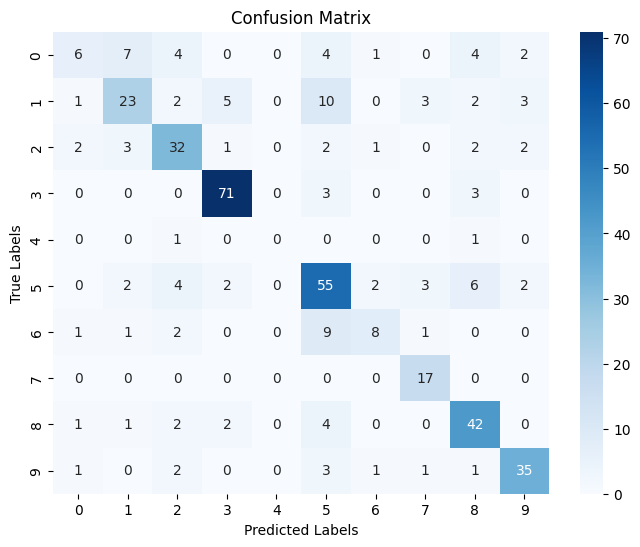

Accuracy: 0.7015


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(test_dataset["labels"])

# Step 2: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(true_labels.numpy(), predicted_labels.numpy()))  # Adjust class names as needed

# Step 3: Plot the confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Optional - Accuracy Calculation
accuracy = (predicted_labels == true_labels).float().mean()
print(f"Accuracy: {accuracy:.4f}")


<ipython-input-76-743b17d2a2c2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: 

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        28
           1       0.62      0.47      0.53        49
           2       0.65      0.71      0.68        45
           3       0.88      0.92      0.90        77
           4       0.00      0.00      0.00         2
           5       0.61      0.72      0.66        76
           6       0.62      0.36      0.46        22
           7       0.68      1.00      0.81        17
           8       0.69      0.81      0.74        52
           9       0.80      0.80      0.80        44

    accuracy                           0.70       412
   macro avg       0.60      0.60      0.59       412
weighted avg       0.69      0.70      0.69       412



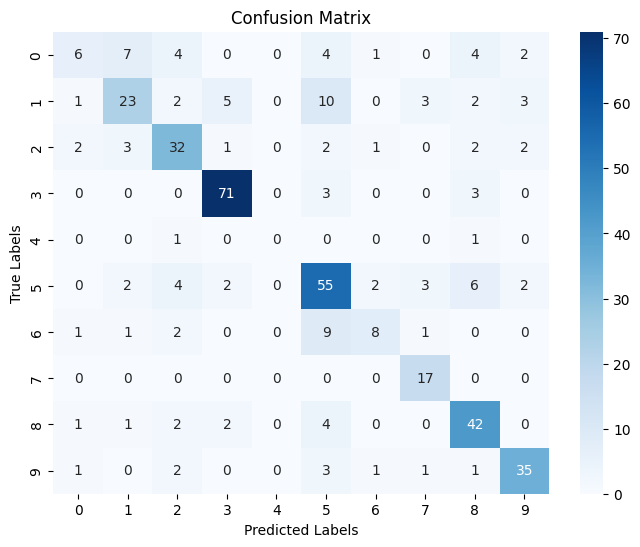

Accuracy: 0.7015


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(test_dataset["labels"])

# Step 2: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(true_labels.numpy(), predicted_labels.numpy()))  # Adjust class names as needed

# Step 3: Plot the confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Optional - Accuracy Calculation
accuracy = (predicted_labels == true_labels).float().mean()
print(f"Accuracy: {accuracy:.4f}")


<ipython-input-65-743b17d2a2c2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])


Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.50      0.39        28
           1       0.35      0.24      0.29        49
           2       0.48      0.56      0.52        45
           3       0.72      0.69      0.70        77
           4       0.00      0.00      0.00         2
           5       0.75      0.47      0.58        76
           6       0.41      0.41      0.41        22
           7       0.21      0.53      0.30        17
           8       0.72      0.60      0.65        52
           9       0.58      0.66      0.62        44

    accuracy                           0.53       412
   macro avg       0.45      0.47      0.45       412
weighted avg       0.57      0.53      0.54       412



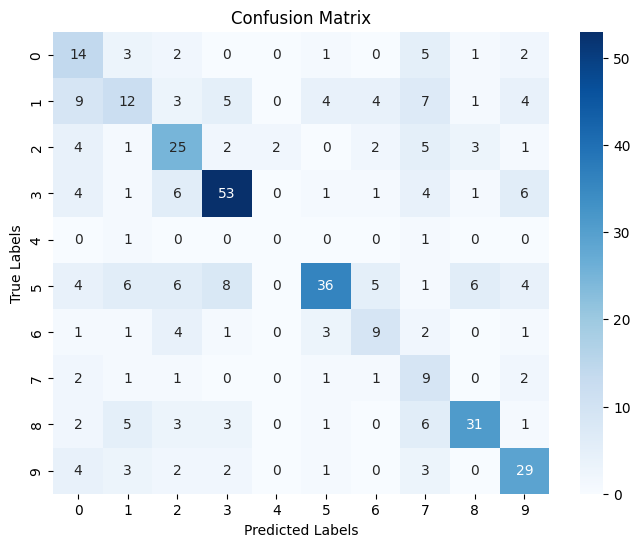

Accuracy: 0.5291


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(test_dataset["labels"])

# Step 2: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(true_labels.numpy(), predicted_labels.numpy()))  # Adjust class names as needed

# Step 3: Plot the confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Optional - Accuracy Calculation
accuracy = (predicted_labels == true_labels).float().mean()
print(f"Accuracy: {accuracy:.4f}")


In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("burakaytan/roberta-base-turkish-uncased")

# Print the model configuration
print(model.config.max_position_embeddings)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at burakaytan/roberta-base-turkish-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


514


In [ ]:
# Loop through the dataset and print the lengths of input_ids
for idx, example in enumerate(train_dataset):
    input_ids_length = len(example['input_ids'])

    # Print the index and length if it's not equal to 4096
    if input_ids_length != 4096:
        print(f"Example {idx} has a length of {input_ids_length} (not 4096)")


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",                  # Directory to save model checkpoints
    eval_strategy="steps",                   # Evaluate every 'logging_steps'
    save_strategy="steps",                   # Save model checkpoints every 'logging_steps'
    logging_steps=10,                        # Log every 10 steps
    num_train_epochs=8,                      # Number of epochs
    per_device_train_batch_size=16,          # Batch size for training
    per_device_eval_batch_size=16,           # Batch size for evaluation
    weight_decay=0.01,                       # Regularization
    load_best_model_at_end=True,             # Load the best model at the end of training
    metric_for_best_model="eval_accuracy",  # Metric to determine best model
    evaluation_strategy="steps",             # Evaluate model after each logging step
    eval_steps=50,                          # Evaluate every 100 steps
    logging_dir="./logs",                    # Directory for logs
    report_to="wandb",                       # Report to W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Pass the compute_metrics function
)

trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.evaluate()

{'eval_accuracy': 0.6399026763990268,
 'eval_loss': 1.8917242288589478,
 'eval_runtime': 11.4151,
 'eval_samples_per_second': 36.005,
 'eval_steps_per_second': 2.278,
 'epoch': 5.0}

In [ ]:
print(train_dataset.column_names)


['text', 'label', '__index_level_0__']


In [ ]:
from pickle import TUPLE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-ZçÇğĞıİöÖşŞüÜ\s]', '', text)

    # Convert text to lowercase
    text = text.casefold()

    # Remove stop words (if necessary)
    words = text.split()
    words = [word for word in words if word not in turkish_stopwords]
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Rejoin the words into a cleaned text string
    return ' '.join(words)

train_profile_df['biography'] = train_profile_df['biography'].apply(preprocess_text)
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)  # You can adjust the max_features as needed

# Fit and transform the 'biography' column to get the TF-IDF matrix
X_tfidf = vectorizer.fit_transform(train_profile_df['biography'])

# Binarize the TF-IDF matrix (convert all non-zero values to 1)
X_binary = (X_tfidf > 0).astype(int)

# Convert the sparse matrix to a dense matrix and store each row as a list
train_profile_df['biography_vector'] = list(X_binary.toarray())

# Display the DataFrame with the new 'biography_vector' column
print(train_profile_df[['biography', 'biography_vector']].head())

                                           biography  \
0              mediaplanning mediabuying sosyalmedya   
1  sogutozuftz avm ankara macrocenter migroslarda...   
2         dijital i̇letişim yönetimiinfovimerangcomq   
3                             talas belediye baskanı   
4  türkiyenin ilindeki yaygın elektrikli şarj ist...   

                                    biography_vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [ ]:
train_profile_df["biography_vector"][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_profile_df.dtypes

username                             object
full_name                            object
biography                            object
category_name                         int64
follower_count                        int64
following_count                       int64
is_business_account                    bool
is_private                             bool
is_verified                            bool
highlight_reel_count                  int64
country_block                          bool
external_url                         object
has_clips                              bool
hide_like_and_view_counts              bool
is_professional_account                bool
is_supervision_enabled                 bool
is_guardian_of_viewer                  bool
is_supervised_by_viewer                bool
is_supervised_user                     bool
is_embeds_disabled                     bool
is_joined_recently                     bool
category_enum                         int64
is_verified_by_mv4b                    bool
is_regulated_c18                       bool
should_show_category                   bool
should_show_public_contacts            bool
show_account_transparency_details      bool
category                             object
biography_vector                     object
dtype: object

In [ ]:
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])

In [ ]:
biography_vector_df


biography_0  biography_1  biography_2  biography_3  biography_4  \
0               0            0            0            0            0   
1               0            0            1            0            1   
2               0            0            0            0            0   
3               0            0            0            0            0   
4               0            0            0            0            0   
...           ...          ...          ...          ...          ...   
2736            0            0            0            0            0   
2737            0            0            0            0            0   
2738            0            0            0            0            0   
2739            0            0            0            0            0   
2740            0            0            0            0            0   

      biography_5  biography_6  biography_7  biography_8  biography_9  ...  \
0               0            0            0            0            0  ...   
1               0            0            0            0            0  ...   
2               0            0            0            0            0  ...   
3               0            0            1            0            0  ...   
4               0            0            0            0            0  ...   
...           ...          ...          ...          ...          ...  ...   
2736            0            0            0            0            0  ...   
2737            0            0            0            0            0  ...   
2738            0            0            0            0            0  ...   
2739            0            0            0            0            0  ...   
2740            0            0            0            0            0  ...   

      biography_90  biography_91  biography_92  biography_93  biography_94  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2736             0             0             0             0             0   
2737             0             0             0             0             0   
2738             0             0             0             0             0   
2739             0             0             0             0             0   
2740             0             0             0             0             0   

      biography_95  biography_96  biography_97  biography_98  biography_99  
0                0             0             0             0             0  
1                0             0             0             0             0  
2                0             0             0             0             0  
3                0             0             0             0             0  
4                0             0             0             0             0  
...            ...           ...           ...           ...           ...  
2736             0             0             0             0             0  
2737             0             0             0             1             0  
2738             0             0             0             0             0  
2739             0             0             0             0             0  
2740             0             0             0             0             0  

[2741 rows x 100 columns]

In [ ]:
X = pd.concat([X, biography_vector_df], axis=1)

NameError: name 'X' is not defined

In [ ]:
X

follower_count  following_count  is_business_account  is_private  \
0               1167              192                    1           0   
1              11997               17                    1           0   
2               2321              454                    1           0   
3              13647               29                    1           0   
4               7917               11                    1           0   
...              ...              ...                  ...         ...   
2736            9259              968                    1           0   
2737            1149              894                    1           0   
2738            1065               10                    1           0   
2739            1379               63                    1           0   
2740           11805             2561                    1           0   

      is_verified  highlight_reel_count  country_block  has_clips  \
0               0                     6              0          1   
1               0                    15              0          1   
2               0                    11              0          1   
3               1                     2              0          1   
4               1                     7              0          1   
...           ...                   ...            ...        ...   
2736            0                     6              0          1   
2737            0                     5              0          1   
2738            0                    10              0          1   
2739            0                    24              0          1   
2740            0                    13              0          1   

      hide_like_and_view_counts  is_professional_account  ...  biography_90  \
0                             0                        1  ...           0.0   
1                             0                        1  ...           0.0   
2                             1                        1  ...           0.0   
3                             0                        1  ...           0.0   
4                             0                        1  ...           0.0   
...                         ...                      ...  ...           ...   
2736                          0                        1  ...           0.0   
2737                          0                        1  ...           0.0   
2738                          0                        1  ...           0.0   
2739                          0                        1  ...           0.0   
2740                          0                        1  ...           0.0   

      biography_91  biography_92  biography_93  biography_94  biography_95  \
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
2736           0.0           0.0           0.0           0.0           0.0   
2737           0.0           0.0           0.0           0.0           0.0   
2738           0.0           0.0           0.0           0.0           0.0   
2739           0.0           0.0           0.0           0.0           0.0   
2740           0.0           0.0           0.0           0.0           0.0   

      biography_96  biography_97  biography_98  biography_99  
0              0.0           0.0      0.000000           0.0  
1              0.0           0.0      0.000000           0.0  
2              0.0           0.0      0.000000           0.0  
3              0.0           0.0      0.000000           0.0  
4              0.0           0.0      0.000000           0.0  
...            ...      

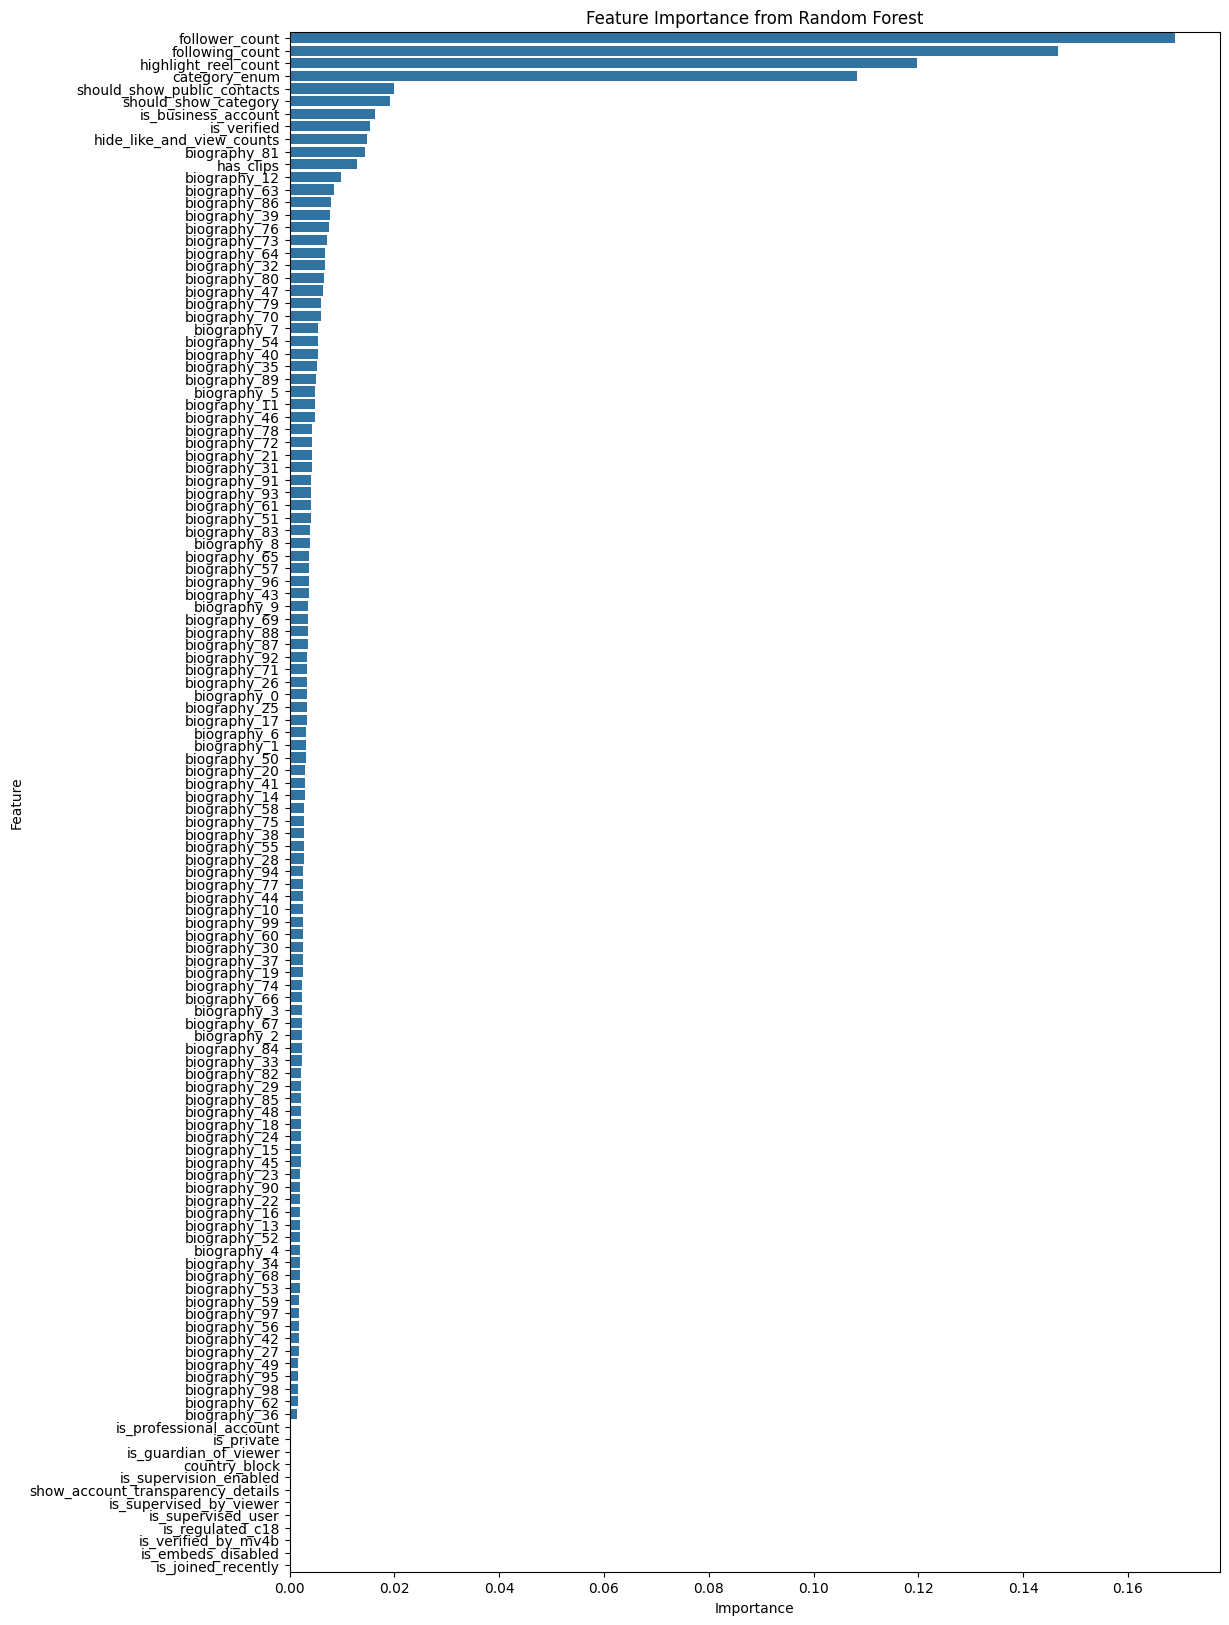

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the features (X) and target variable (y)
# Drop 'category', 'username', 'full_name', 'category_name', 'biography', 'external_url'
# 'biography_vector' will be added later, so we exclude it from the initial X
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url','biography_vector'])

# Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
# Ensure 'biography_vector' is a list of arrays, then expand it into multiple columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])

# Combine the original features with the 'biography_vector'
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 2: Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Step 3: Extract feature importances
importances = rf.feature_importances_

# Step 4: Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Step 5: Visualize the feature importances
plt.figure(figsize=(12, 20))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Step 1: Prepare the features (X) and target variable (y)
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector'])

# Step 2: Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the SVM model with default parameters
svm = SVC(random_state=42)  # Using the default parameters
svm.fit(X_train_scaled, y_train)

# Step 6: Predict on the test set
y_pred = svm.predict(X_test_scaled)

# Step 7: Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.3005464480874317

Classification Report:
                      precision    recall  f1-score   support

                 art       0.33      0.03      0.05        38
       entertainment       0.21      0.32      0.26        59
             fashion       0.19      0.11      0.14        55
                food       0.33      0.62      0.43       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.27      0.41      0.33        96
    mom and children       0.40      0.06      0.10        34
              sports       0.75      0.11      0.19        27
                tech       0.30      0.19      0.23        59
              travel       0.68      0.21      0.32        62

            accuracy                           0.30       549
           macro avg       0.35      0.21      0.20       549
        weighted avg       0.35      0.30      0.27       549



c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Step 1: Prepare the features (X) and target variable (y)
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector'])

# Step 2: Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Hyperparameter tuning using GridSearchCV
# We will tune the C, kernel, and gamma parameters for the SVM classifier.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}



grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Step 6: Best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Step 7: Train the SVM model with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)

# Step 8: Predict on the test set
y_pred = best_svm.predict(X_test_scaled)

# Step 9: Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters from GridSearchCV: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy Score: 0.30965391621129323

Classification Report:
                      precision    recall  f1-score   support

                 art       0.50      0.05      0.10        38
       entertainment       0.21      0.32      0.25        59
             fashion       0.23      0.15      0.18        55
                food       0.33      0.63      0.43       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.28      0.41      0.33        96
    mom and children       0.40      0.06      0.10        34
              sports       0.75      0.11      0.19        27
                tech       0.33      0.20      0.25        59
              travel       0.72      0.21      0.33        62

            accuracy                           0.31       549
           macro avg       0.38      0.21      0.22       549
        weighted avg       0.38      0.31      0.28   

c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
import ast
import pandas as pd

# Step 1: Check the 'biography_vector' column for problematic entries
train_profile_df['biography_vector'].head()

# Step 2: Replace any null values or strings with empty lists (or another default)
train_profile_df['biography_vector'] = train_profile_df['biography_vector'].fillna("[]")

# Step 3: Safely convert the string representation of lists into actual lists using ast.literal_eval
train_profile_df['biography_vector'] = train_profile_df['biography_vector'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 4: If the column is already in list form, you can split it into individual columns if needed
# Example: If 'biography_vector' is a list of numbers, you can expand it into new columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].tolist())

# Optional: Combine the vectorized features with the rest of the DataFrame
X = pd.concat([train_profile_df.drop(columns=['biography_vector']), biography_vector_df], axis=1)

# Check the result
X.head()


username                     full_name  \
0            deparmedya                   Depar Medya   
1            kafesfirin                   KAFES FIRIN   
2              vimerang                      Vimerang   
3     mustafa_yalcinn38               Mustafa Yalçın   
4  zorluenergysolutions  ZES (Zorlu Energy Solutions)   

                                           biography  category_name  \
0              mediaplanning mediabuying sosyalmedya            185   
1  sogutozuftz avm ankara macrocenter migroslarda...             42   
2          dijital iletişim yönetimiinfovimerangcomq            333   
3                             talas belediye baskanı            244   
4  türkiyenin ilindeki yaygın elektrikli şarj ist...            333   

   follower_count  following_count  is_business_account  is_private  \
0            1167              192                 True       False   
1           11997               17                 True       False   
2            2321              454                 True       False   
3           13647               29                 True       False   
4            7917               11                 True       False   

   is_verified  highlight_reel_count  ...   90   91   92   93   94   95   96  \
0        False                     6  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        False                    15  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        False                    11  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3         True                     2  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4         True                     7  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    97   98   99  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  

[5 rows x 128 columns]

In [ ]:
test_profile_df.head(2)

username          id                    full_name  \
0              beyazyakaliyiz  8634457436           Selam Beyaz Yakalı   
1  totalenergies_istasyonlari  7066643793  TotalEnergies İstasyonları   

                                           biography   category_name  \
0        Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀   Personal blog   
1  TotalEnergies İstasyonları resmi Instagram hes...  Energy Company   

  post_count follower_count following_count is_business_account is_private  \
0       None           1265             665                True      False   
1       None          28025               4                True      False   

   ... business_category_name overall_category_name   category_enum  \
0  ...                   None                  None   PERSONAL_BLOG   
1  ...                   None                  None  ENERGY_COMPANY   

  is_verified_by_mv4b is_regulated_c18  \
0               False            False   
1               False            False   

                                     profile_pic_url should_show_category  \
0  https://instagram.fist6-1.fna.fbcdn.net/v/t51....                 True   
1  https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....                 True   

  should_show_public_contacts show_account_transparency_details  \
0                        True                              True   
1                        True                              True   

                              profile_picture_base64  
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  

[2 rows x 44 columns]

In [ ]:
train_profile_df["business_contact_method"]

KeyError: 'business_contact_method'

In [ ]:
with pd.option_context('display.max_columns', None):
    print(train_profile_df.head())


               username          id                     full_name  \
0            deparmedya  3170700063                   Depar Medya   
1            kafesfirin   266439571                   KAFES FIRIN   
2              vimerang  2367195567                      Vimerang   
3     mustafa_yalcinn38  9606564254               Mustafa Yalçın   
4  zorluenergysolutions  8155780357  ZES (Zorlu Energy Solutions)   

                                           biography   category_name  \
0           #mediaplanning #mediabuying #sosyalmedya  Local business   
1  📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...           Brand   
2       Dijital İletişim Yönetimi🎬info@vimerang.comq            None   
3                            Talas Belediye Başkanı      Politician   
4  Türkiye’nin 81 ilindeki en yaygın elektrikli ş...            None   

  follower_count following_count is_business_account is_private is_verified  \
0           1167             192                True      False       Fal

In [ ]:
train_profile_df.dtypes

username                             object
id                                   object
full_name                            object
biography                            object
category_name                        object
follower_count                       object
following_count                      object
is_business_account                  object
is_private                           object
is_verified                          object
highlight_reel_count                 object
bio_links                            object
entities                             object
country_block                        object
eimu_id                              object
external_url                         object
fbid                                 object
has_clips                            object
hide_like_and_view_counts            object
is_professional_account              object
is_supervision_enabled               object
is_guardian_of_viewer                object
is_supervised_by_viewer         

#TF_IDF
words are not numbers, we should transform them to numerical values

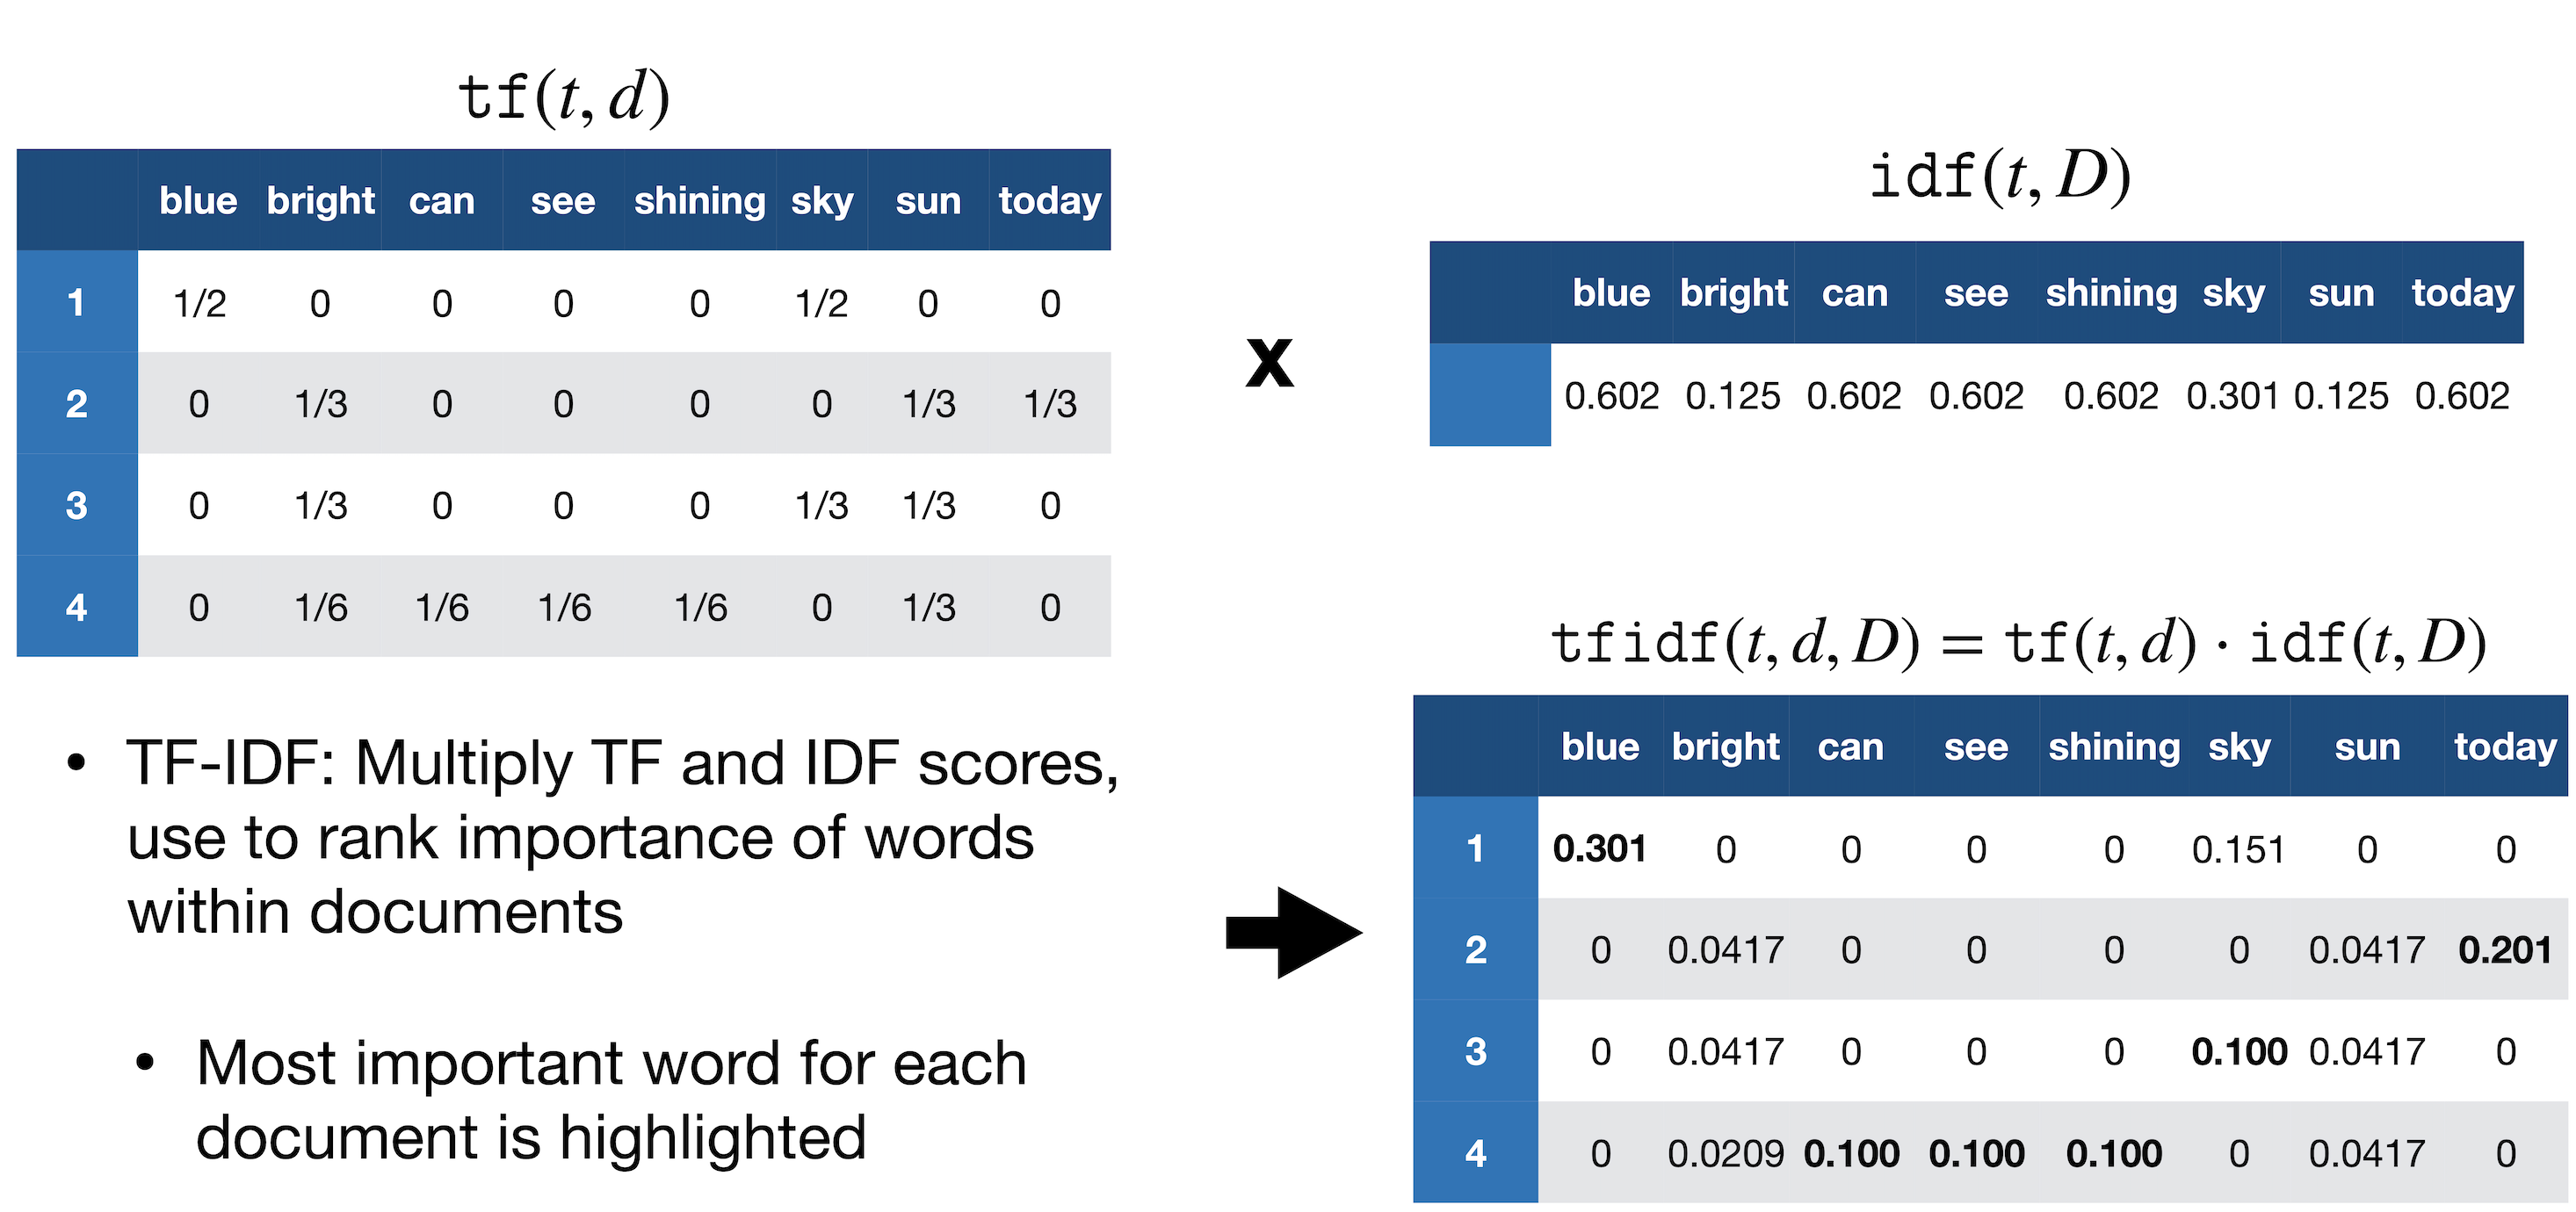

# Let's check the documentation of scikit-learn
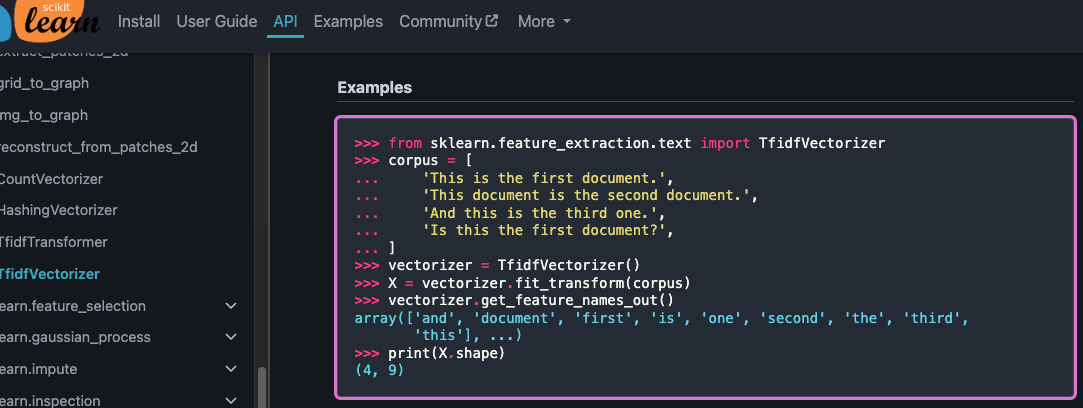

Here our corpus is all of our post data
so we should concat aggregate all of them and provide as a corpus to the Tf-IDF vectorizer of the scikit-learn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import torch

In [ ]:
from torch import Tensor

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification

# Load a pre-trained Turkish BERT model
model_name = 'dbmdz/bert-base-turkish-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForTokenClassification.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch import Tensor
print(Tensor)


<class 'torch.Tensor'>


In [ ]:
def preprocess_text(text: str):
    # Lower casing Turkish Text, avoiding str.lower
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

   # Tokenize the text
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))

    # Load stopwords for the specified language

    # Filter out stopwords
    filtered_text = [w for w in tokens if w.lower() not in turkish_stopwords]

    if len(filtered_text) > 512:
        filtered_text = filtered_text[:512]

    # Return the text as a sentence
    return " ".join(filtered_text)

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')  # Make sure this is done
nltk.download('stopwords')  # Ensure stopwords are available

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# Example text
text = "Merhaba, nasılsın? Bugün hava çok güzel."

# Tokenize the text
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
print(tokens)


['[CLS]', 'Merhaba', ',', 'nasıl', '##sın', '?', 'Bugün', 'hava', 'çok', 'güzel', '.', '[SEP]']


In [ ]:
import pandas as pd

# Initialize lists to store usernames and aggregated posts
train_usernames = []
corpus = []
for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        # Preprocess the text (e.g., remove stopwords, tokenize, etc.)
        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

# Create a DataFrame with username and posts columns
data = pd.DataFrame({
    "username": train_usernames,
    "posts": corpus
})

# Display the DataFrame
print(data)



Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


                   username                                              posts
0                deparmedya  [CLS] cumhuriyet ##imizin yılı kutlu olsun [SE...
1                kafesfirin  [CLS] bugün bir fincan köpük ##lü türk kahve #...
2                  vimerang  [CLS] saygı özlem ##le # atatürk # kasım # kas...
3         mustafa_yalcinn38  [CLS] altın ##oluk çevre şehir ##cilik iklim d...
4      zorluenergysolutions  [CLS] güne enerji ##k bir sohbet devam etmek i...
...                     ...                                                ...
2736    tatlidunyasidergisi  [CLS] emel ##ay ##din ##bu ##tik ##pas ##ta ##...
2737  yerindengelsin.com.tr  [CLS] # ber ##line ##r # alman ##ek ##me ##ği ...
2738       woodtechistanbul  [CLS] söyledikleri ##m hakikat olduğu gün send...
2739               netsvadi  [CLS] net ##s vad ##ide nefes kamp ##i ara ##l...
2740          herbisiatolye  [CLS] gur ##d ##ji ##eff kutsal dans ##ları öğ...

[2741 rows x 2 columns]


In [ ]:
# Adding a category column based on username2_category
data['category'] = [
    username2_category.get(uname, "NA") for uname in data['username']
]


In [ ]:
data['label'] = data['category'].factorize()[0]
data.head()

username                                              posts  \
0            deparmedya  [CLS] cumhuriyet ##imizin yılı kutlu olsun [SE...   
1            kafesfirin  [CLS] bugün bir fincan köpük ##lü türk kahve #...   
2              vimerang  [CLS] saygı özlem ##le # atatürk # kasım # kas...   
3     mustafa_yalcinn38  [CLS] altın ##oluk çevre şehir ##cilik iklim d...   
4  zorluenergysolutions  [CLS] güne enerji ##k bir sohbet devam etmek i...   

               category  label  
0                  tech      0  
1                  food      1  
2                  tech      0  
3  health and lifestyle      2  
4                  tech      0

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report

In [ ]:
# Split the dataset into training and testing data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Tokenize the data
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_df.posts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df.posts.tolist(), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Create input pipelines
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df.label))
train_dataset = train_dataset.shuffle(len(train_df)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df.label))
test_dataset = test_dataset.batch(32)

In [ ]:
# Define the model
num_labels = len(train_df.label.unique())
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Train the model
from tensorflow import optimizers, losses, metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics.SparseCategoricalAccuracy()
)

In [ ]:
model.fit(train_dataset, epochs=5)

Epoch 1/5



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # Lower casing Turkish Text, avoiding str.lower
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Prepare training data
train_usernames = []
corpus = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)





# Map usernames to their categories
y_train = [username2_category.get(username, "NA") for username in train_usernames]

# Prepare test data
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)


# Map test usernames to their categories
y_test = [username2_category.get(username, "NA") for username in test_usernames]

# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

test_data = {
    "username": test_usernames,
    "features": test_corpus,
    "labels": y_test
}

import pandas as pd

# Convert the train data dictionary to a DataFrame
train_df = pd.DataFrame(train_data)

# Convert the test data dictionary to a DataFrame
test_df = pd.DataFrame(test_data)

# Display the first few rows of the train and test DataFrames
print("Sample Training Data (DataFrame):")
print(train_df.head())

print("Sample Test Data (DataFrame):")
print(test_df.head())
train_df["features"]


Sample Training Data:
Username: deparmedya
Label: tech,cumhuriyetimizin yılı kutlu olsun
oriflame duologi lansmanı #isveçtengelengüzellik #oriflameilesaçbakımdevrimi
#oriflameilesaçbakımdevrimi
#oriflameilesaçbakımdevrimi agustos oriflameturkiye
agustos #oriflameturkiye #duoloji
oriflame #duoloji
muhteşem saçların sırrı #duoloji oriflameturkiye
goe elektirikli motorsiklet ile sürdürülebilir bir yaşamın elçisi olun#goeilegeleceğeyönver #goeilesürdürülebilirgelecek #easytorideeasytolove goemobility
haziran #yazamerhaba feridaistanbul
haziran #yazamerhaba
feridaistanbul #yazamerhaba feridacadde
jumbopatisserienin edible art konseptiyle özel olarak hazırlanan tatlıları ve baci milanonun şık ve renkli dünyasında kahvaltıdayız#jumboturkiye
easy to love easy to ride goemobility
figamortr
mustafa kemal atatürkü sevgisaygı ve özlemle anıyoruz
notecosmetiqueturkiye #event #kendimenote
notecosmetiqueturkiye
otoshops outdoor çalışmaları otoshopsturkiye
mad parfüm outdoor çalışmalarımız madparfumeu

Sample Training Data (DataFrame):
               username                                           features  \
0            deparmedya  cumhuriyetimizin yılı kutlu olsun\noriflame du...   
1            kafesfirin  bugün bir fincan köpüklü türk kahvesiyle taçla...   
2              vimerang  saygı ve özlemle #atatürk #kasım #kasim #vimer...   
3     mustafa_yalcinn38  altınoluk çevre şehircilik ve iklim değişikliğ...   
4  zorluenergysolutions  güne enerjik bir sohbet ile devam etmek ister ...   

                 labels  
0                  tech  
1                  food  
2                  tech  
3  health and lifestyle  
4                  tech  
Sample Test Data (DataFrame):
                     username  \
0              beyazyakaliyiz   
1  totalenergies_istasyonlari   
2                 konforyatak   
3                    ht_kulup   
4                   ajansspor   

                                            features labels  
0  bu diyaloğun yaşanmadığı bir online toplantı o.

0       cumhuriyetimizin yılı kutlu olsun\noriflame du...
1       bugün bir fincan köpüklü türk kahvesiyle taçla...
2       saygı ve özlemle #atatürk #kasım #kasim #vimer...
3       altınoluk çevre şehircilik ve iklim değişikliğ...
4       güne enerjik bir sohbet ile devam etmek ister ...
                              ...                        
2736    emelaydinbutikpastacilik butikpastacilarderneg...
2737    #berliner #almanekmeği #hercumartesi\n#almanba...
2738    bu söylediklerim hakikat olduğu gün senden ve ...
2739    nets vadide nefes kampi aralik az sayıda kişi ...
2740    gurdjieff kutsal dansları ve öğretisi çalışmas...
Name: features, Length: 2741, dtype: object

In [ ]:
import tensorflow as tf
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


GPU Devices: []


In [ ]:
import pandas as pd

# Convert the TF-IDF features into a DataFrame for easier merging
vector_df = pd.DataFrame(
    x_post_train.toarray(),  # Convert sparse matrix to dense
    index=train_usernames,  # Use usernames as the index
    columns=[f'feature_{i}' for i in range(x_post_train.shape[1])]  # Feature names
)

# Add the vectors as a single array column to `train_profile_df`
# First, create a column where each entry is a numpy array of the TF-IDF features
vector_df['tfidf_vector'] = vector_df.apply(lambda row: row.values, axis=1)

# Merge the vector column with `train_profile_df`
train_profile_df = train_profile_df.merge(
    vector_df[['tfidf_vector']],  # Only merge the tfidf_vector column
    left_on='username',  # Merge on the username column
    right_index=True,  # Use the index of vector_df as the right key
    how='left'  # Perform a left join to preserve all rows in train_profile_df
)

# Check the result
print(train_profile_df[['username', 'tfidf_vector']].head())


               username                                       tfidf_vector
0            deparmedya  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1            kafesfirin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2              vimerang  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     mustafa_yalcinn38  [0.047264336546735265, 0.0, 0.0, 0.0, 0.0, 0.0...
4  zorluenergysolutions  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),  # Assuming 'tfidf_vector' is the column name for TF-IDF vectors
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Step 2: Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Debugging: Ensure all columns in X are numeric
assert all(pd.api.types.is_numeric_dtype(X[col]) for col in X.columns), "Non-numeric data found in features!"

# Target variable
y = train_profile_df['category']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train SVM model
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

# Step 6: Predictions
y_pred = svm.predict(X_test_scaled)

# Step 7: Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.4918032786885246

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.03      0.05        38
       entertainment       0.44      0.27      0.34        59
             fashion       0.57      0.47      0.51        55
                food       0.85      0.73      0.78       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.29      0.84      0.43        96
    mom and children       0.00      0.00      0.00        34
              sports       1.00      0.04      0.07        27
                tech       0.66      0.63      0.64        59
              travel       0.76      0.40      0.53        62

            accuracy                           0.49       549
           macro avg       0.56      0.34      0.34       549
        weighted avg       0.61      0.49      0.46       549



c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 1: Encode string labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert string labels to integers

# Split the encoded labels
y_train, y_test = train_test_split(y_encoded, test_size=0.2, random_state=42)

# Step 2: Convert integer labels to one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
# Step 4: Define the MLP model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output layer with softmax
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train_scaled, y_train_categorical, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

print("Accuracy Score:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))


Epoch 1/10


c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Could not interpret metric identifier: F1-Score

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Encode string labels as integers (Label Encoding)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert string labels to integers
y_test_encoded = label_encoder.transform(y_test)  # Apply the same encoding to the test labels

# Step 5: Define and train the MLP model from scikit-learn
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train_scaled, y_train_encoded)

# Step 6: Evaluate the model
y_pred = mlp.predict(X_test_scaled)

# Get accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy Score:", accuracy)

# Classification report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))


NameError: name 'train_profile_df' is not defined

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
captioner("https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png")
## [{'generated_text': 'two birds are standing next to each other '}]


ModuleNotFoundError: No module named 'transformers'

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize XGBClassifier
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train_scaled, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Accuracy Score:", accuracy_xgb)


XGBoost Accuracy Score: 0.6120218579234973


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Step 1: Prepare the Features and Target
# Assuming you have already prepared your X and y
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])
# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))])
# Expand 'tfidf_vector' into multiple columns
tfidf_df = pd.DataFrame(train_profile_df['tfidf_vector'].to_list(), columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))])
# Concatenate features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling (important for many models, but not strictly necessary for RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Encode Labels (if needed for classification)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 5: Initialize the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 6: Train the Random Forest Model
rf_model.fit(X_train_scaled, y_train_encoded)

# Step 7: Make Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Step 8: Evaluate the Model
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print("Random Forest Accuracy Score:", accuracy_rf)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Accuracy Score: 0.5919854280510018

Random Forest Classification Report:
                      precision    recall  f1-score   support

                 art       0.29      0.05      0.09        38
       entertainment       0.37      0.44      0.40        59
             fashion       0.59      0.76      0.67        55
                food       0.76      0.93      0.84       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.48      0.65      0.55        96
    mom and children       0.50      0.03      0.06        34
              sports       1.00      0.11      0.20        27
                tech       0.62      0.83      0.71        59
              travel       0.69      0.55      0.61        62

            accuracy                           0.59       549
           macro avg       0.53      0.44      0.41       549
        weighted avg       0.59      0.59      0.55       549



c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None,  20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best hyperparameters and model
best_rf_model = grid_search.best_estimator_

# Evaluate the model
y_pred_rf_best = best_rf_model.predict(X_test_scaled)
accuracy_rf_best = accuracy_score(y_test_encoded, y_pred_rf_best)
print("Optimized Random Forest Accuracy Score:", accuracy_rf_best)
print("\nOptimized Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_best, target_names=label_encoder.classes_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Optimized Random Forest Accuracy Score: 0.599271402550091

Optimized Random Forest Classification Report:
                      precision    recall  f1-score   support

                 art       0.20      0.03      0.05        38
       entertainment       0.36      0.41      0.38        59
             fashion       0.61      0.75      0.67        55
                food       0.75      0.94      0.84       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.49      0.69      0.57        96
    mom and children       0.67      0.06      0.11        34
              sports       1.00      0.11      0.20        27
                tech       0.64      0.83      0.72        59
              travel       0.72      0.58      0.64        62

            accuracy                           0.60       549
           macro avg       0.54      0.44      0.42       549
        weighted avg     

c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []


for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [ ]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      shape=(5000,), dtype=object)

In [ ]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

abdullah  abone  about  accompanied  acele  acil  activities  acı   ad  \
0       0.0    0.0    0.0          0.0    0.0   0.0         0.0  0.0  0.0   
1       0.0    0.0    0.0          0.0    0.0   0.0         0.0  0.0  0.0   

   ada  ...  şubemiz  şubesi  şölen  şöleni  şöyle  şükranla  şükür       şık  \
0  0.0  ...      0.0     0.0    0.0     0.0    0.0       0.0    0.0  0.050596   
1  0.0  ...      0.0     0.0    0.0     0.0    0.0       0.0    0.0  0.000000   

   şıklık  şıklığı  
0     0.0      0.0  
1     0.0      0.0  

[2 rows x 5000 columns]

In [ ]:
df_tfidf.shape

(2741, 5000)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [ ]:
x_train.shape

(2192, 5000)

In [ ]:
x_val.shape

(549, 5000)